In [1]:
#importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from optuna.trial import Trial
import time
from pandas.plotting import autocorrelation_plot
import scipy
from scipy import stats
from scipy.signal import welch
from scipy.signal import spectrogram
from scipy.stats import entropy
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, RocCurveDisplay
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from statsmodels.stats.outliers_influence import OLSInfluence
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import plotly.express as px
import plotly.graph_objects as go
import optuna
import joblib

In [2]:
set1 = pd.read_csv("./set1_timefeatures.csv") #Reading the data again

In [3]:
#Changing indexing column to time which is also name of the each file
set1 = set1.rename(columns={'Unnamed: 0':'time'})
set1.set_index('time')
set1.describe()
set1.head()

,time,B1_mean,B1_std,B1_skew,B1_kurtosis,B1_entropy,B1_rms,B1_max,B1_p2p,B1_crest,...,B4_skew,B4_kurtosis,B4_entropy,B4_rms,B4_max,B4_p2p,B4_crest,B4_clearence,B4_shape,B4_impulse
0,2003-10-22 12:06:24,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,...,0.046532,0.790686,4.607008,0.109019,0.413,0.662,3.788316,0.085565,1.149963,4.356424
1,2003-10-22 12:09:13,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,...,0.085152,1.235094,4.590646,0.108900,0.420,0.796,3.856749,0.086097,1.145471,4.417794
2,2003-10-22 12:14:13,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,...,0.009628,0.925042,4.602957,0.110320,0.396,0.657,3.589548,0.086970,1.147284,4.118232
3,2003-10-22 12:19:13,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,...,-0.037240,0.652947,4.604434,0.111038,0.393,0.591,3.539320,0.087623,1.146925,4.059336
4,2003-10-22 12:24:13,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,...,0.036435,0.635987,4.594110,0.110189,0.376,0.591,3.412315,0.087316,1.143544,3.902132


Health Status labels are added according to following dictionary

In [4]:
B1 ={
    "early" : ["2003-10-22 12:06:24" , "2003-10-23 09:14:13"],
    "suspect" : ["2003-10-23 09:24:13" , "2003-11-08 12:11:44"],
    "normal" : ["2003-11-08 12:21:44" , "2003-11-19 21:06:07"],
    "suspect" : ["2003-11-19 21:16:07" , "2003-11-24 20:47:32"],
    "imminent_failure" : ["2003-11-24 20:57:32","2003-11-25 23:39:56"]
}
B2 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-24 01:01:24"],
    "suspect" : ["2003-11-24 01:11:24" , "2003-11-25 10:47:32"],
    "imminent_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B3 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-22 09:16:56"],
    "suspect" : ["2003-11-22 09:26:56" , "2003-11-25 10:47:32"],
    "Inner_race_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B4 = {
    "early" : ["2003-10-22 12:06:24" , "2003-10-29 21:39:46"],
    "normal" : ["2003-10-29 21:49:46" , "2003-11-15 05:08:46"],
    "suspect" : ["2003-11-15 05:18:46" , "2003-11-18 19:12:30"],
    "Rolling_element_failure" : ["2003-11-19 09:06:09" , "2003-11-22 17:36:56"],
    "Stage_two_failure" : ["2003-11-22 17:46:56" , "2003-11-25 23:39:56"]
}

In [5]:
B1_state = list()
B2_state = list()
B3_state = list()
B4_state = list()
cnt = 0

for _ in set1.index:
    cnt += 1
    # B1
    if cnt <= 151:
        B1_state.append("early")
    elif 151 < cnt <= 600:
        B1_state.append("suspect")
    elif 600 < cnt <= 1499:
        B1_state.append("normal")
    elif 1499 < cnt <= 2098:
        B1_state.append("suspect")
    elif 2098 < cnt <= 2156:
        B1_state.append("imminent_failure")
    else:
        B1_state.append(None)

    # B2
    if cnt <= 500:
        B2_state.append("early")
    elif 500 < cnt <= 2000:
        B2_state.append("normal")
    elif 2000 < cnt <= 2120:
        B2_state.append("suspect")
    elif 2120 < cnt <= 2156:
        B2_state.append("imminent_failure")
    else:
        B2_state.append(None)

    # B3
    if cnt <= 500:
        B3_state.append("early")
    elif 500 < cnt <= 1790:
        B3_state.append("normal")
    elif 1790 < cnt <= 2120:
        B3_state.append("suspect")
    elif 2120 < cnt <= 2156:
        B3_state.append("Inner_race_failure")
    else:
        B3_state.append(None)

    # B4
    if cnt <= 200:
        B4_state.append("early")
    elif 200 < cnt <= 1000:
        B4_state.append("normal")
    elif 1000 < cnt <= 1435:
        B4_state.append("suspect")
    elif 1435 < cnt <= 1840:
        B4_state.append("Inner_race_failure")
    elif 1840 < cnt <= 2156:
        B4_state.append("Stage_two_failure")
    else:
        B4_state.append(None)
#controlling the counts
from collections import Counter
print(Counter(B1_state))
print(Counter(B2_state))
print(Counter(B3_state))
print(Counter(B4_state))

set1["B1_state"] = B1_state
set1["B2_state"] = B2_state
set1["B3_state"] = B3_state
set1["B4_state"] = B4_state

set1.head()

Counter({'suspect': 1048, 'normal': 899, 'early': 151, 'imminent_failure': 58})
Counter({'normal': 1500, 'early': 500, 'suspect': 120, 'imminent_failure': 36})
Counter({'normal': 1290, 'early': 500, 'suspect': 330, 'Inner_race_failure': 36})
Counter({'normal': 800, 'suspect': 435, 'Inner_race_failure': 405, 'Stage_two_failure': 316, 'early': 200})


,time,B1_mean,B1_std,B1_skew,B1_kurtosis,B1_entropy,B1_rms,B1_max,B1_p2p,B1_crest,...,B4_max,B4_p2p,B4_crest,B4_clearence,B4_shape,B4_impulse,B1_state,B2_state,B3_state,B4_state
0,2003-10-22 12:06:24,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,...,0.413,0.662,3.788316,0.085565,1.149963,4.356424,early,early,early,early
1,2003-10-22 12:09:13,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,...,0.420,0.796,3.856749,0.086097,1.145471,4.417794,early,early,early,early
2,2003-10-22 12:14:13,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,...,0.396,0.657,3.589548,0.086970,1.147284,4.118232,early,early,early,early
3,2003-10-22 12:19:13,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,...,0.393,0.591,3.539320,0.087623,1.146925,4.059336,early,early,early,early
4,2003-10-22 12:24:13,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,...,0.376,0.591,3.412315,0.087316,1.143544,3.902132,early,early,early,early


**Splitting each bearing data and adding them end to end vertically**

In [6]:
B1_cols = [col for col in set1.columns if "B1" in col]
B2_cols = [col for col in set1.columns if "B2" in col]
B3_cols = [col for col in set1.columns if "B3" in col]
B4_cols = [col for col in set1.columns if "B4" in col]

B1 = set1[B1_cols]
B2 = set1[B2_cols]
B3 = set1[B3_cols]
B4 = set1[B4_cols]
cols = ['B_mean','B_std','B_skew','B_kurtosis','B_entropy','B_rms','B_max','B_p2p','B_crest', 'B_clearence', 'B_shape', 'B_impulse',
        'class']
B1.columns = cols
B2.columns = cols
B3.columns = cols
B4.columns = cols
final_data = pd.concat([B1,B2,B3,B4], axis=0, ignore_index=True)
final_data.describe()
final_data.head()

,B_mean,B_std,B_skew,B_kurtosis,B_entropy,B_rms,B_max,B_p2p,B_crest,B_clearence,B_shape,B_impulse,class
0,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,0.090932,1.196537,6.913248,early
1,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,0.090784,1.194500,6.309617,early
2,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,0.092058,1.192407,5.931146,early
3,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,0.091833,1.193516,5.700660,early
4,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,0.091479,1.198917,5.945870,early


**Train-Test Split (70%-30%)**

In [7]:
X = final_data.copy()
y = X.pop("class")
le = preprocessing.LabelEncoder() #le is a variable name that you can change and change the 'class' to numerical value
le.fit(y)
y = le.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1)
X_train.shape, X_test.shape

((6036, 12), (2588, 12))

**Evaluating Performance of Base Models**
Now we can compare several learning algorithms

For Random Forest

Accuracy: 0.7546367851622875
F1 Score: 0.74951560781346
Precision: 0.8854461568110127
Recall: 0.6894162323878598


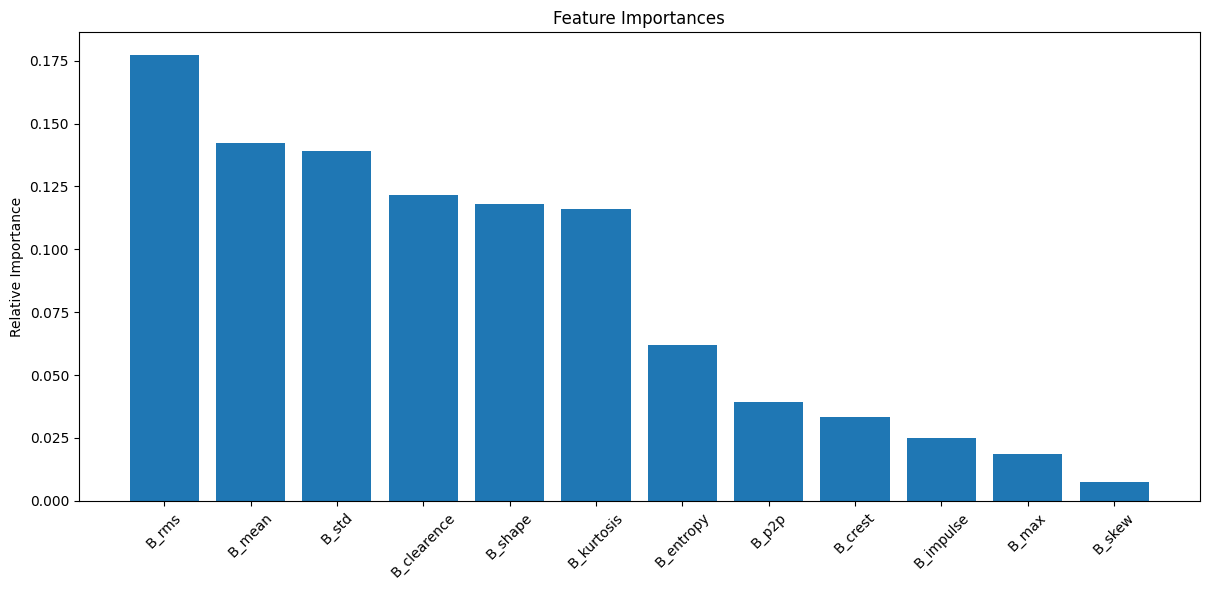

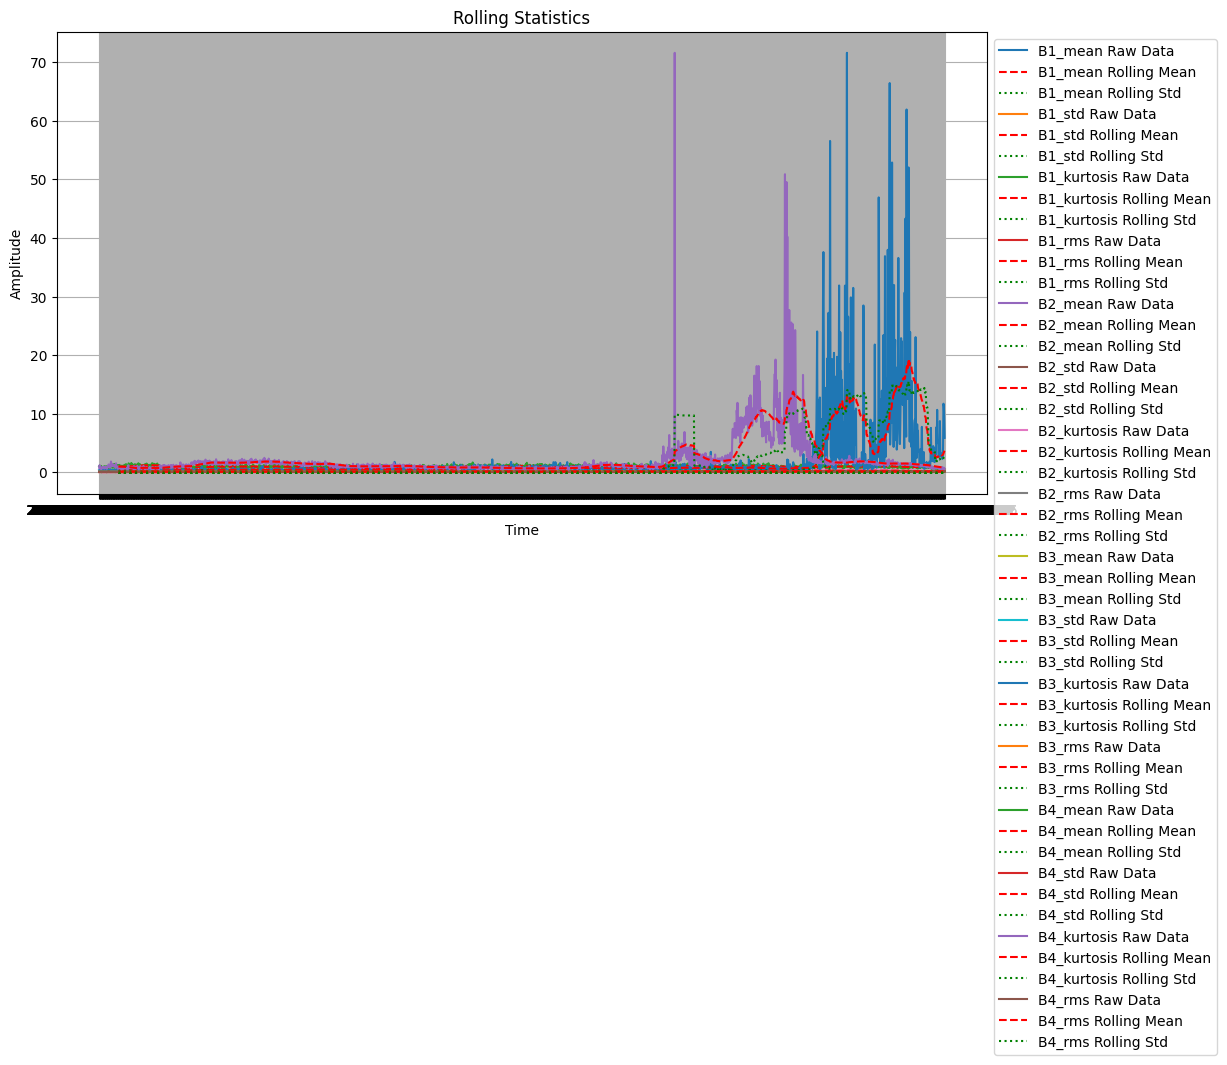

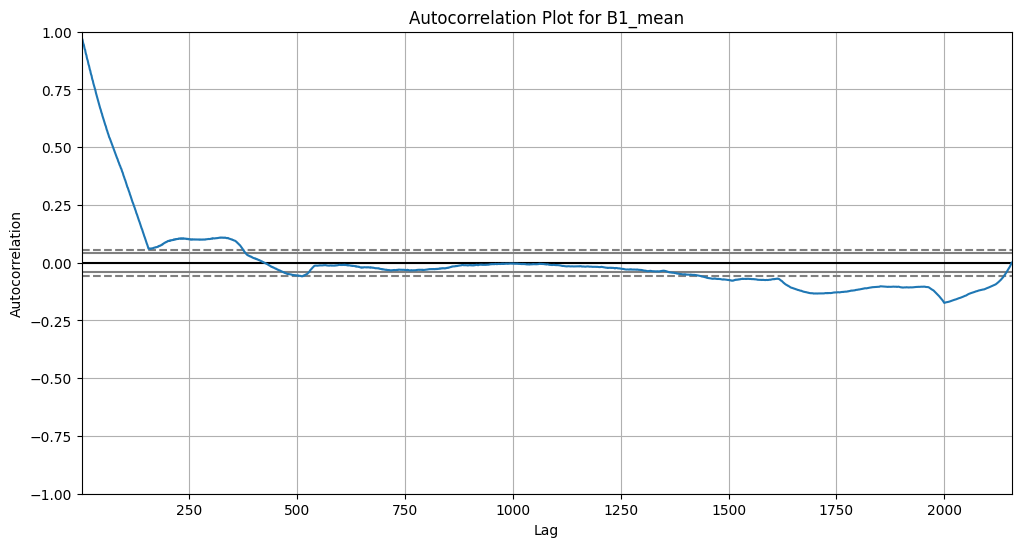

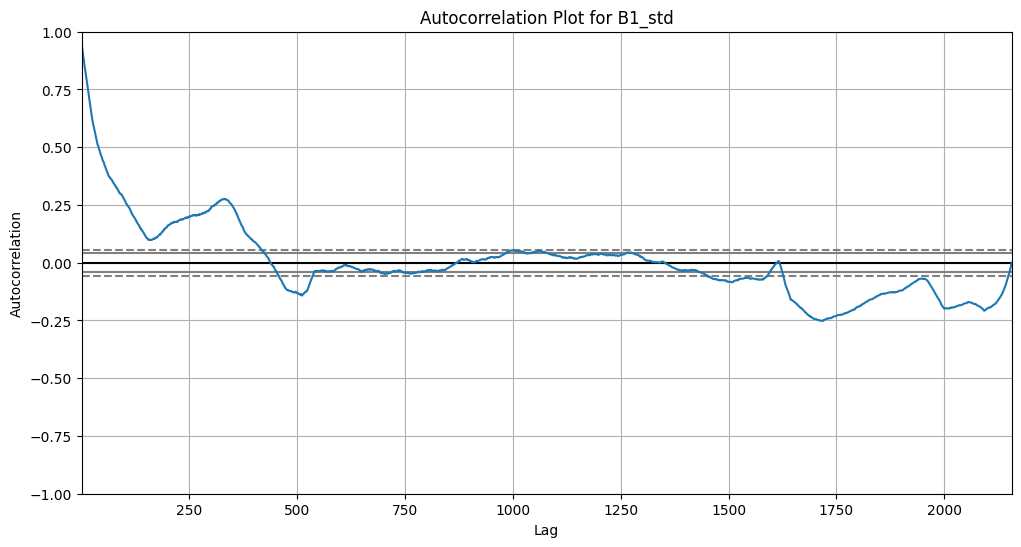

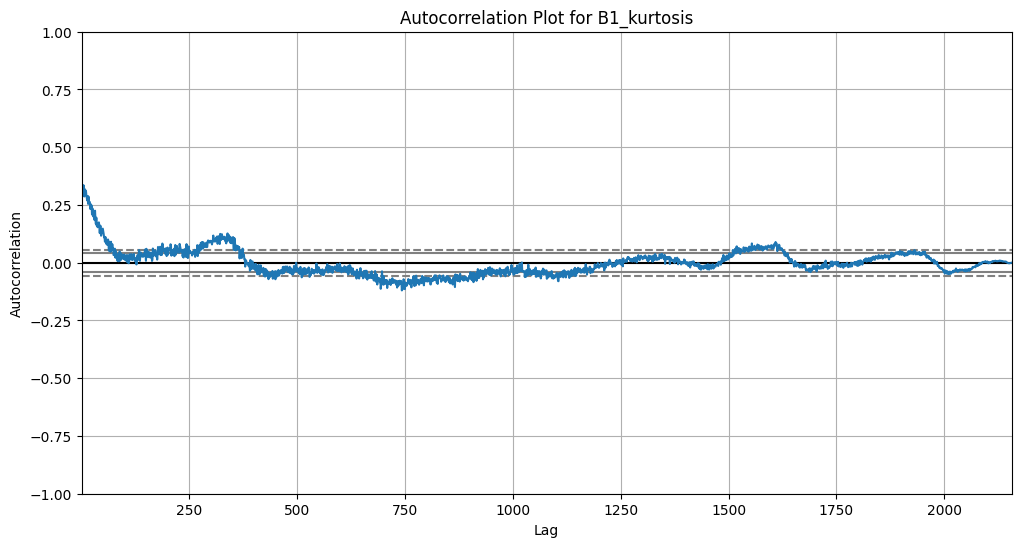

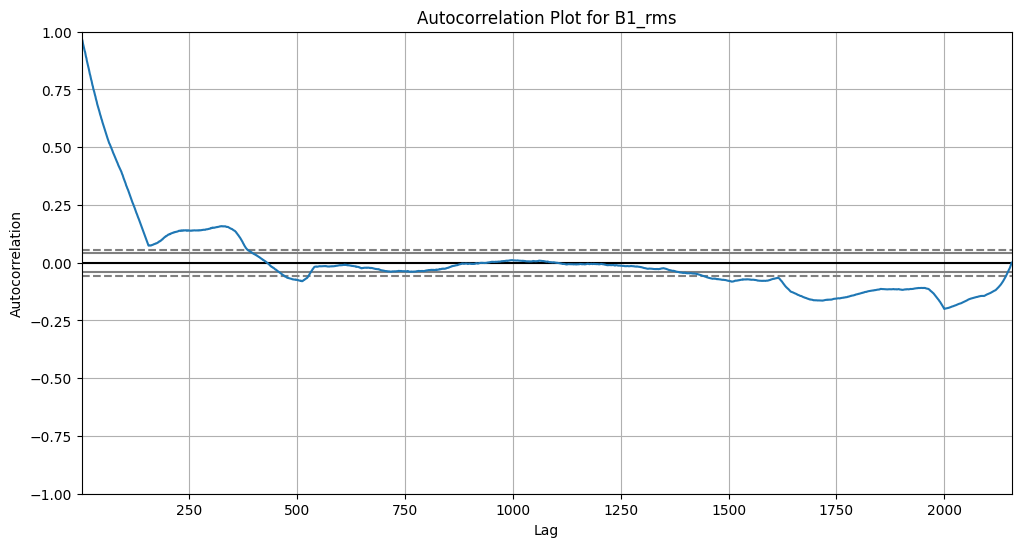

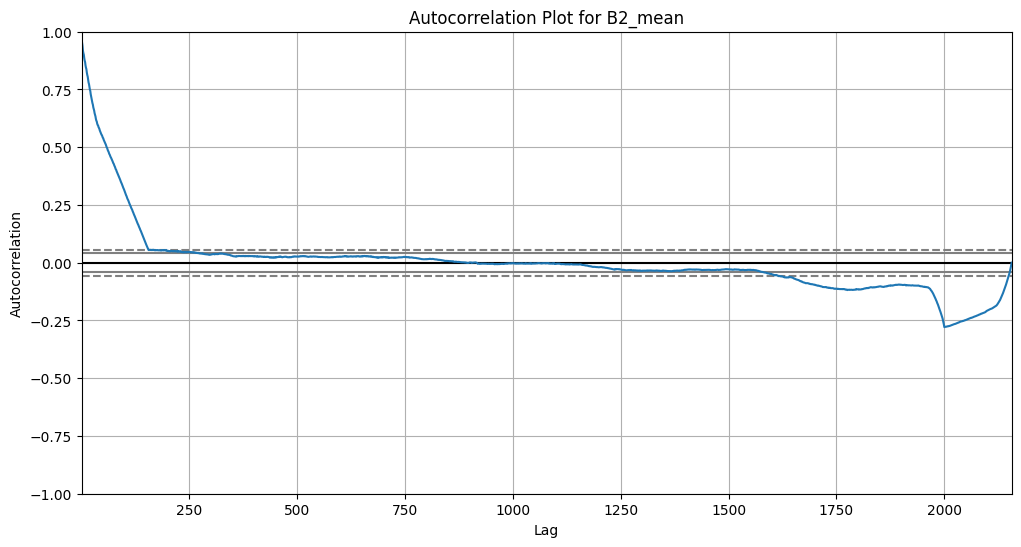

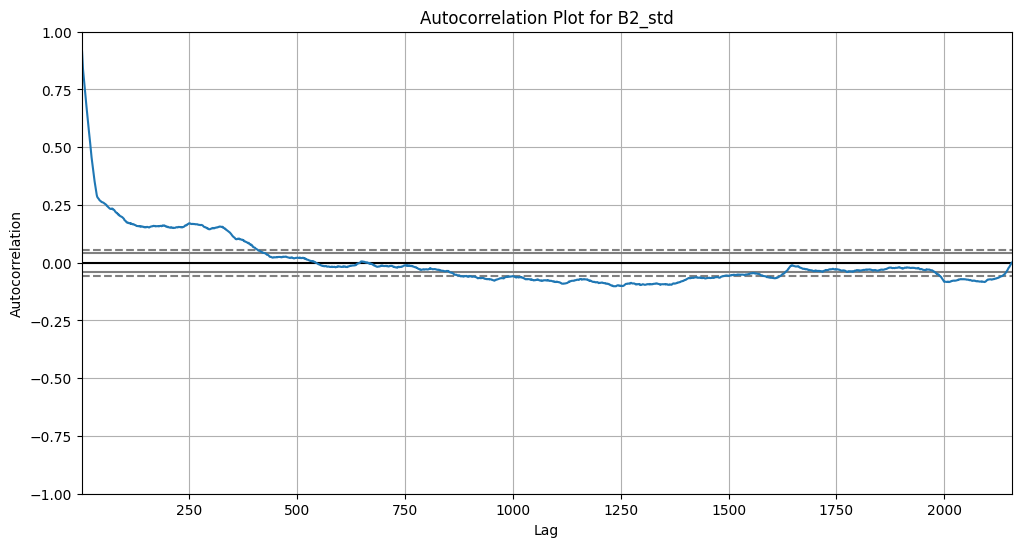

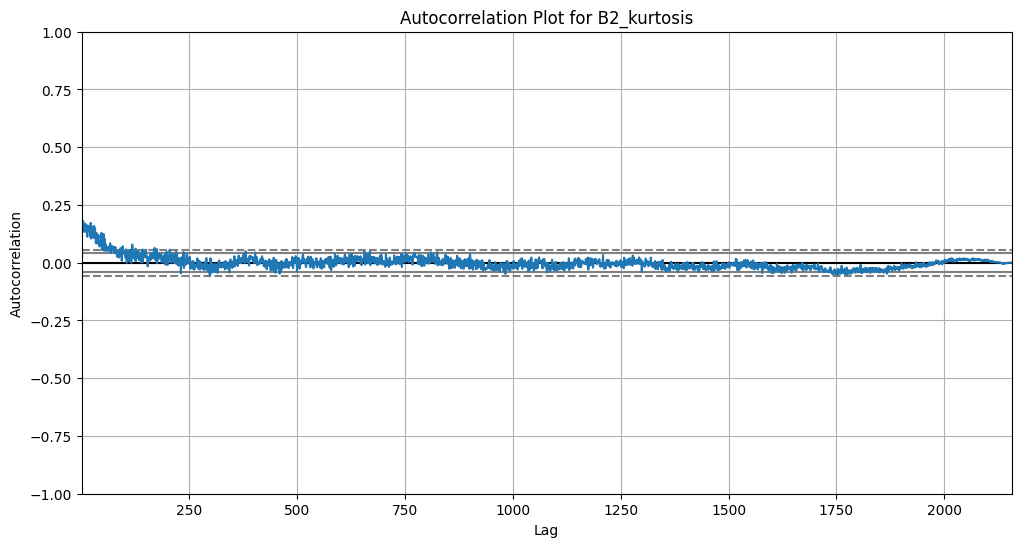

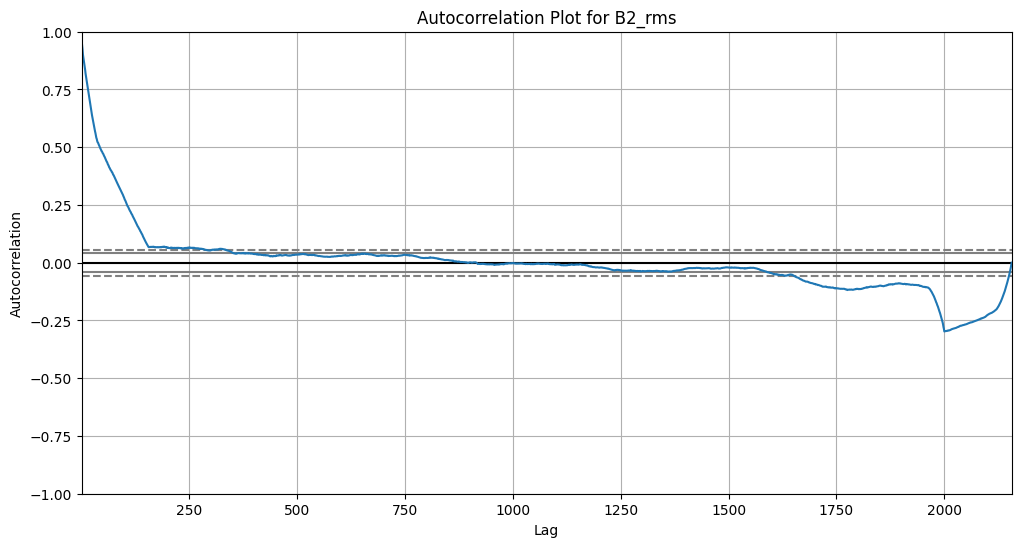

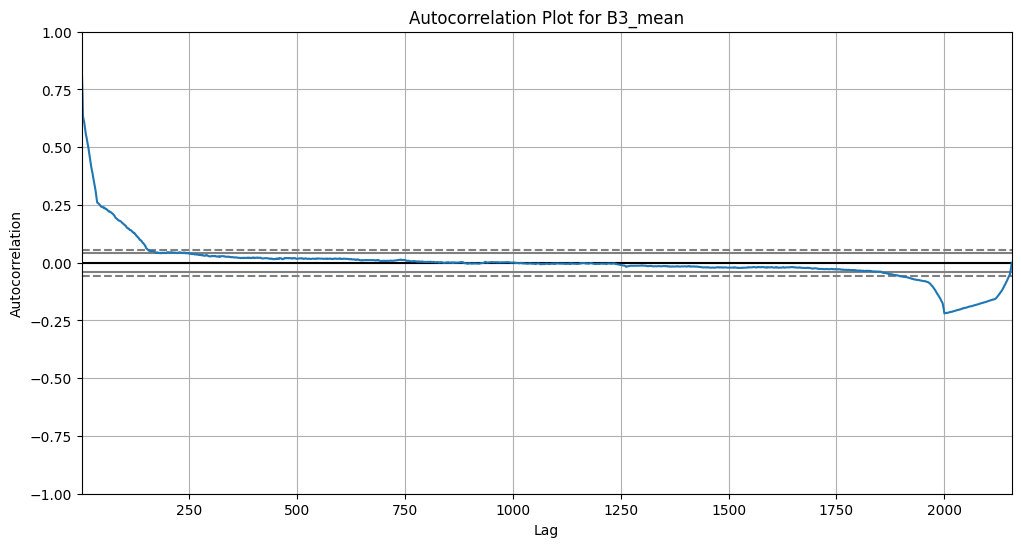

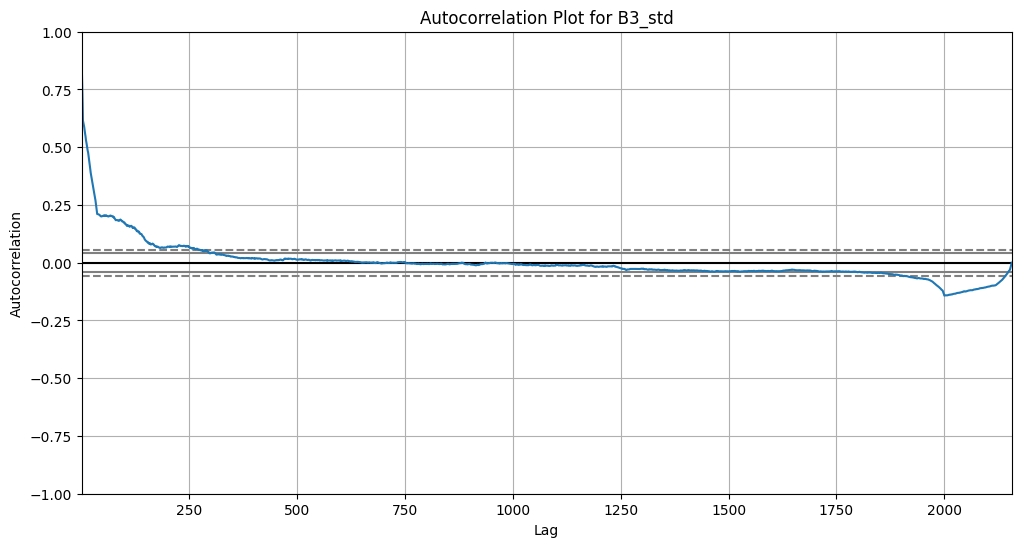

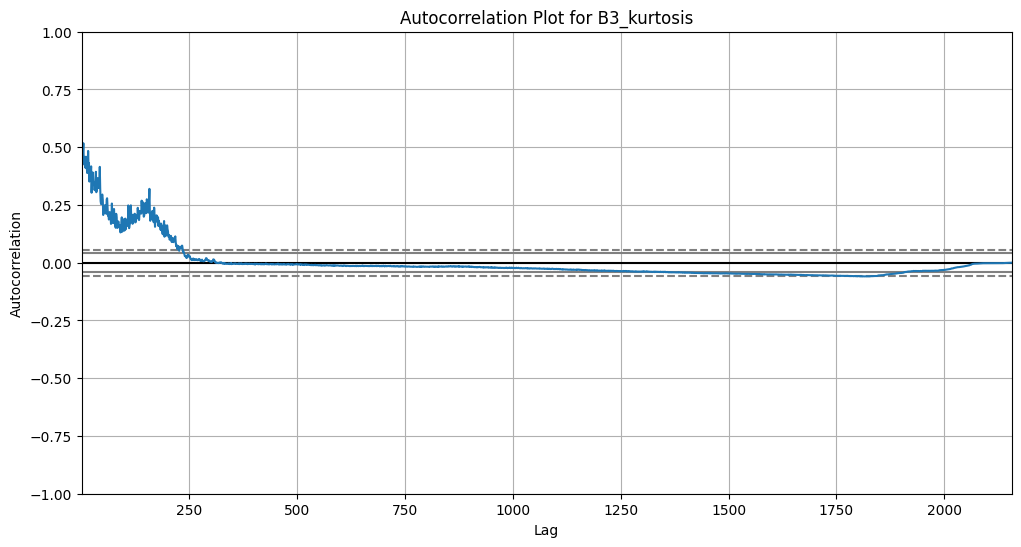

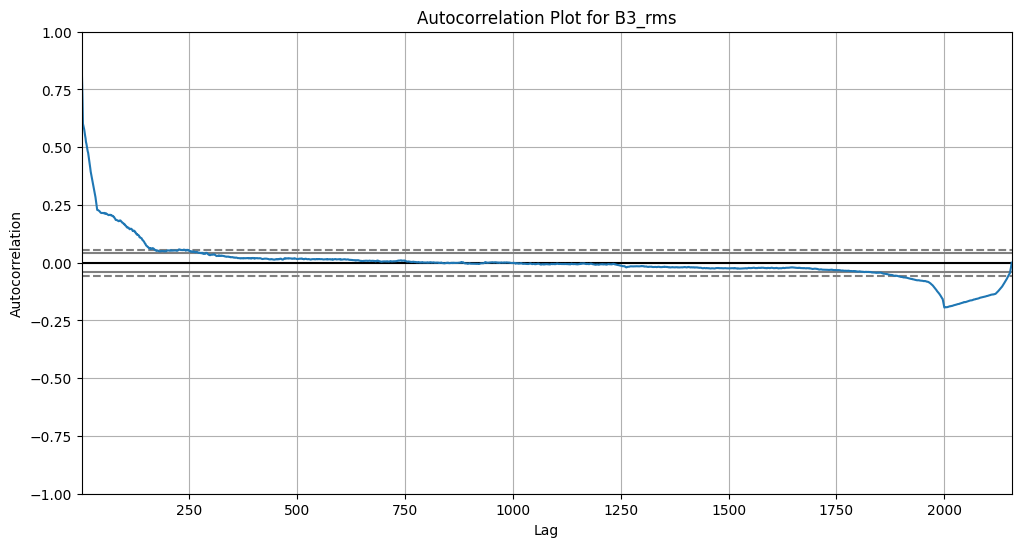

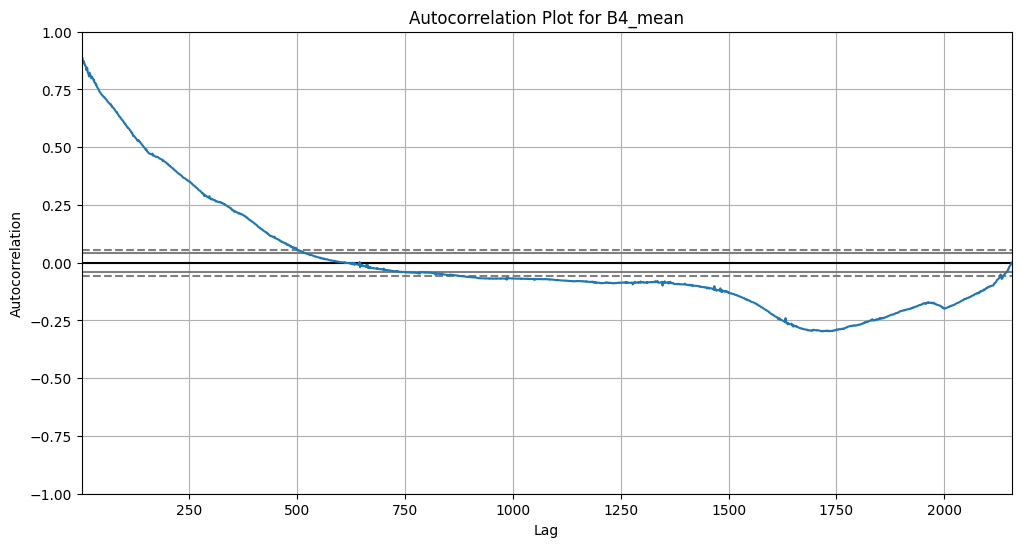

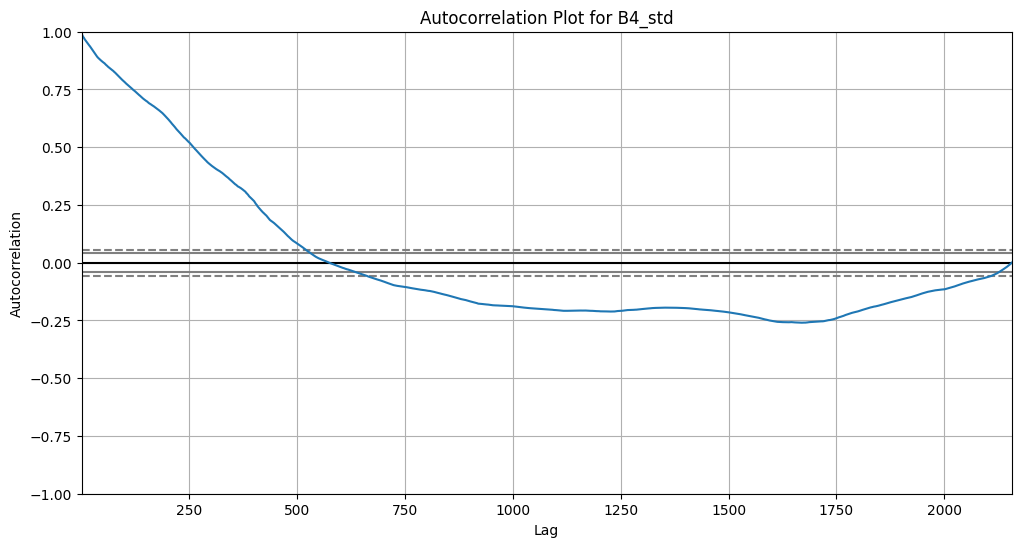

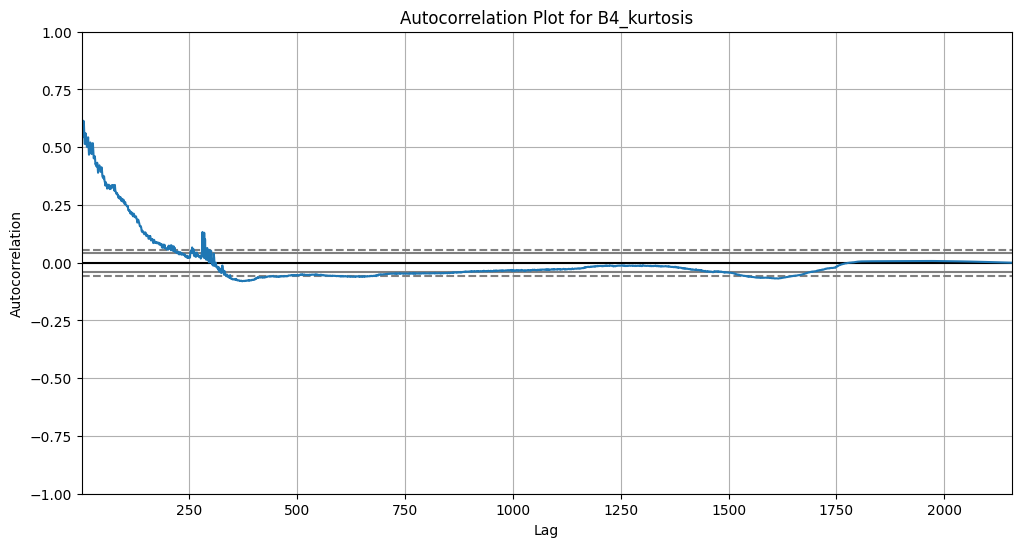

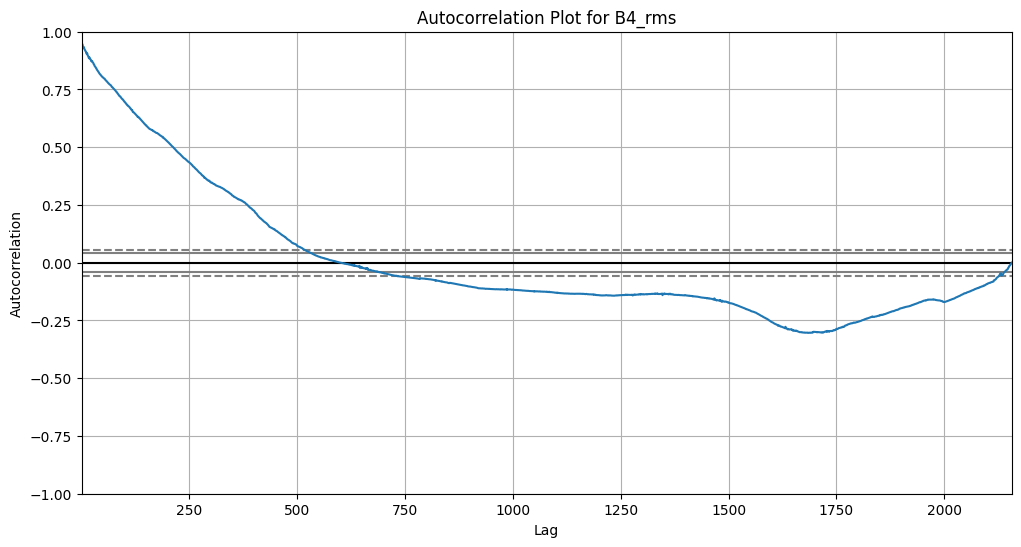

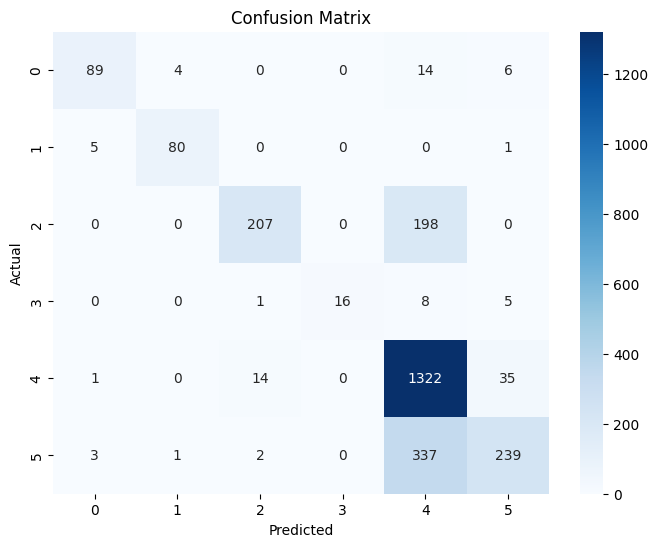

In [8]:
# Define and train the RandomForestClassifier
rf_cl = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt"
)
rf_cl.fit(X_train, y_train)
preds = rf_cl.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds, average='macro')
precision = precision_score(y_test, preds, average='macro')
recall = recall_score(y_test, preds, average='macro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Save intermediate results using joblib
intermediate_results = {
    "model": rf_cl,
    "preds": preds,
    "accuracy": accuracy,
    "f1": f1,
    "precision": precision,
    "recall": recall
}
joblib.dump(intermediate_results, "intermediate_results_rf.pkl")

# 1. PLOT FOR FEATURE IMPORTANCES
# Getting feature importances
importances = rf_cl.feature_importances_
indices = np.argsort(importances)[::-1]

# Plotting the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=45)
plt.tight_layout()
plt.ylabel('Relative Importance')
plt.show()


# 2. Rolling Statistics
window = 50  # Adjust window as needed

# Calculate rolling mean and std for each selected column
for col in ['B1_mean', 'B1_std', 'B1_kurtosis', 'B1_rms', 'B2_mean', 'B2_std', 'B2_kurtosis', 'B2_rms',
            'B3_mean', 'B3_std', 'B3_kurtosis', 'B3_rms', 'B4_mean', 'B4_std', 'B4_kurtosis', 'B4_rms']:
    set1[f'{col}_rolling_mean'] = set1[col].rolling(window=window).mean()
    set1[f'{col}_rolling_std'] = set1[col].rolling(window=window).std()

plt.figure(figsize=(12, 6))
for col in ['B1_mean', 'B1_std', 'B1_kurtosis', 'B1_rms', 'B2_mean', 'B2_std', 'B2_kurtosis', 'B2_rms',
            'B3_mean', 'B3_std', 'B3_kurtosis', 'B3_rms', 'B4_mean', 'B4_std', 'B4_kurtosis', 'B4_rms']:
    plt.plot(set1['time'], set1[col], label=f'{col} Raw Data')
    plt.plot(set1['time'], set1[f'{col}_rolling_mean'], label=f'{col} Rolling Mean', color='red', linestyle='dashed')
    plt.plot(set1['time'], set1[f'{col}_rolling_std'], label=f'{col} Rolling Std', color='green', linestyle='dotted')

plt.title('Rolling Statistics')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Adjust the legend position and bbox_to_anchor to avoid overlap
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()


# 3. Autocorrelation Plot
# Calculate autocorrelation plot for each selected column
for col in ['B1_mean', 'B1_std', 'B1_kurtosis', 'B1_rms', 'B2_mean', 'B2_std', 'B2_kurtosis', 'B2_rms',
            'B3_mean', 'B3_std', 'B3_kurtosis', 'B3_rms', 'B4_mean', 'B4_std', 'B4_kurtosis', 'B4_rms']:
    plt.figure(figsize=(12, 6))
    autocorrelation_plot(set1[col])
    plt.title(f'Autocorrelation Plot for {col}')
    plt.grid(True)
    plt.show()

# 4. Compute confusion matrix
cm = confusion_matrix(y_test, preds)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()






PARAMS OPTIMISER FOR RANDOM FOREST

[I 2023-08-30 01:14:38,704] A new study created in memory with name: no-name-83a29fa7-5a16-4fd9-9e0d-91113a5b2235
[I 2023-08-30 01:16:43,424] Trial 0 finished with value: 0.8431221020092736 and parameters: {'n_estimators': 874, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8431221020092736.
[I 2023-08-30 01:17:03,501] Trial 1 finished with value: 0.6642194744976816 and parameters: {'n_estimators': 414, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8431221020092736.
[I 2023-08-30 01:18:13,318] Trial 2 finished with value: 0.8153013910355487 and parameters: {'n_estimators': 565, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8431221020092736.
[I 2023-08-30 01:18:35,937] Trial 3 finished with value: 0.6649922720247295 and parameters: {'n_estimators': 484, 'max_depth': 2, 'min_

Best Hyperparameters: {'n_estimators': 987, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}
Accuracy: 0.8446676970633694
F1 Score: 0.835647626058265
Precision: 0.9006739405767504
Recall: 0.7970515510762192


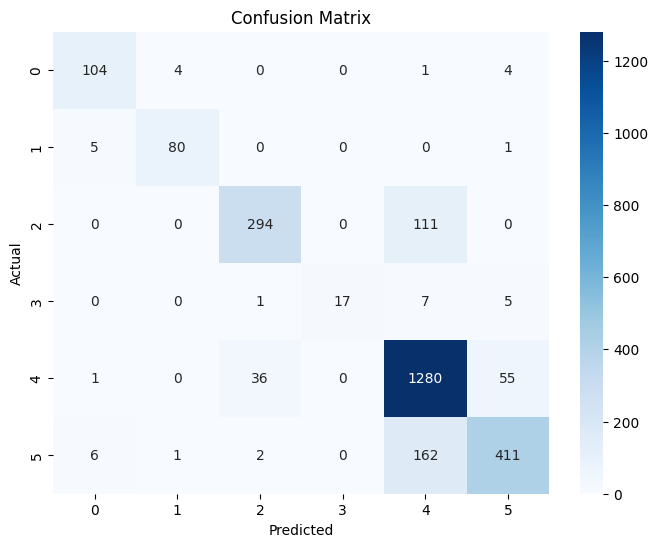

In [32]:
from optuna.trial import Trial

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 2, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    
    rf_cl = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features
    )
    
    rf_cl.fit(X_train, y_train)
    preds = rf_cl.predict(X_test)
    
    accuracy = accuracy_score(y_test, preds)
    return accuracy

# Create a study and optimize it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # You can adjust the number of trials

# Get the best hyperparameters from the study
best_params = study.best_params

# Train the model with the best hyperparameters
best_rf_cl = RandomForestClassifier(**best_params)
best_rf_cl.fit(X_train, y_train)
preds = best_rf_cl.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds, average='macro')
precision = precision_score(y_test, preds, average='macro')
recall = recall_score(y_test, preds, average='macro')
cm = confusion_matrix(y_test, preds)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:", cm)

# Save intermediate results using joblib
intermediate_results = {
    "model": rf_cl,
    "preds": preds,
    "accuracy": accuracy,
    "f1": f1,
    "precision": precision,
    "recall": recall
}
joblib.dump(intermediate_results, "intermediate_results_rf.pkl")

# Confusion Matrix
cm = confusion_matrix(y_test, preds)

# Plotting confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

FOR GRADIENT BOOSTING

Accuracy: 0.8500772797527048
F1 Score: 0.8365869351601817
Precision: 0.8879460905631554
Recall: 0.8057652874407495


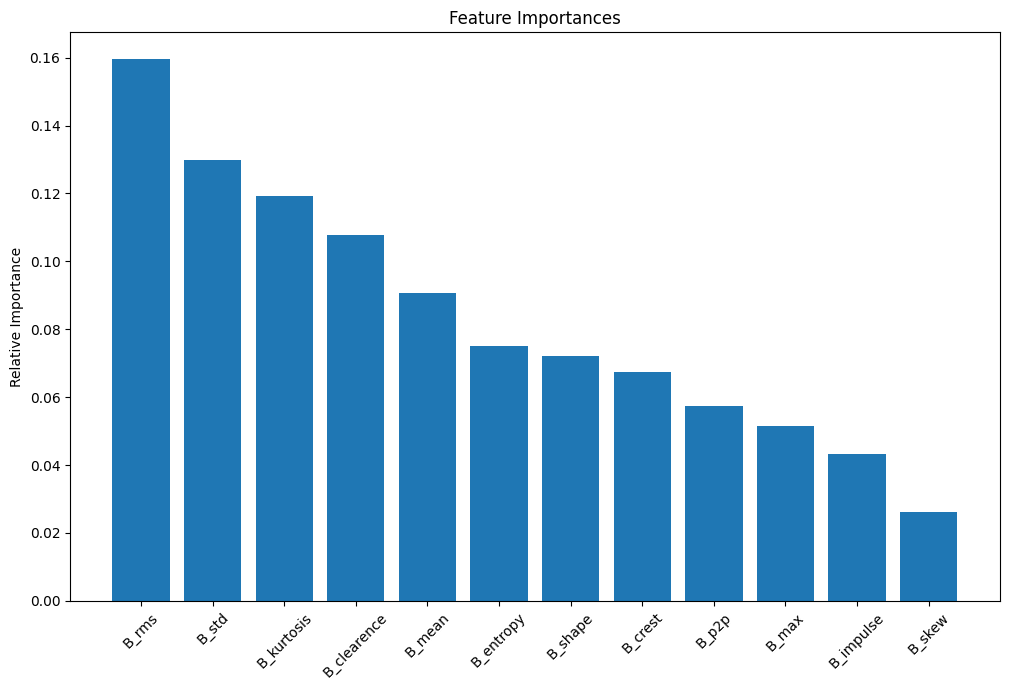

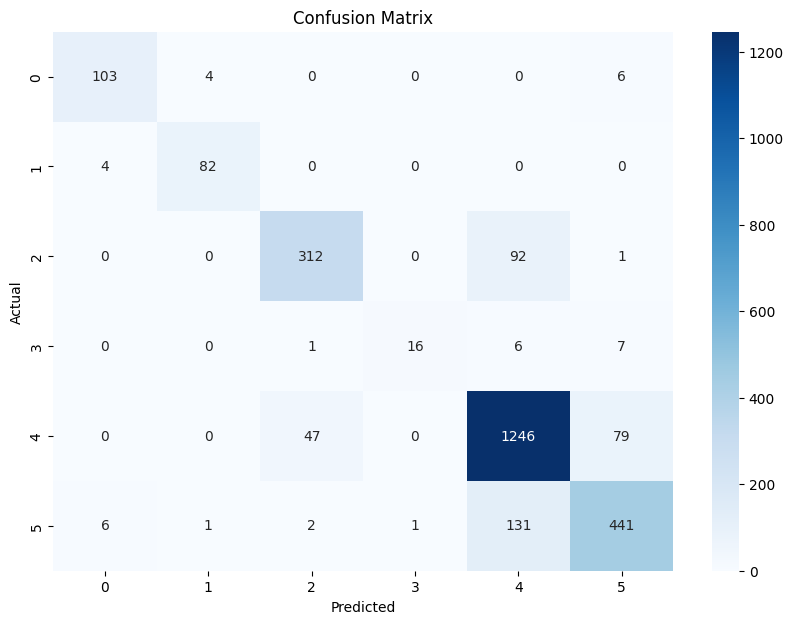

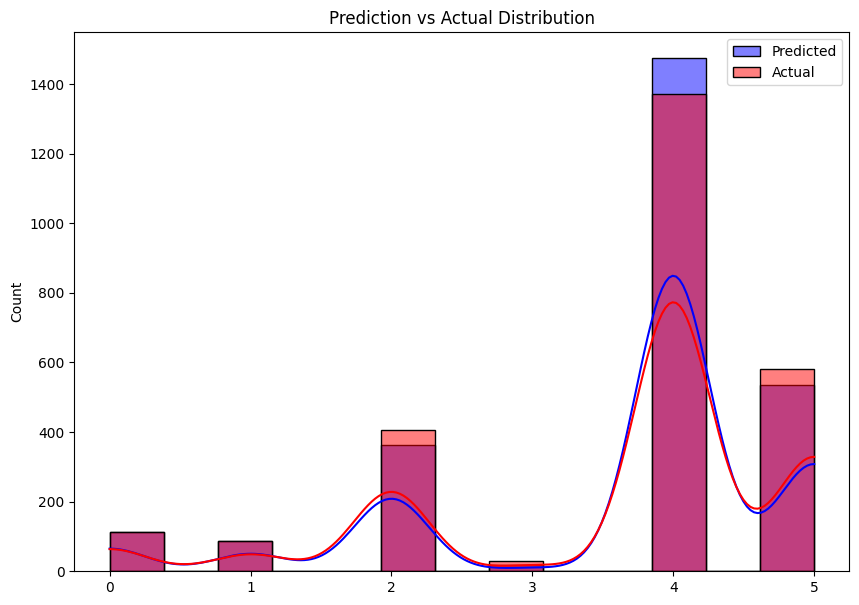

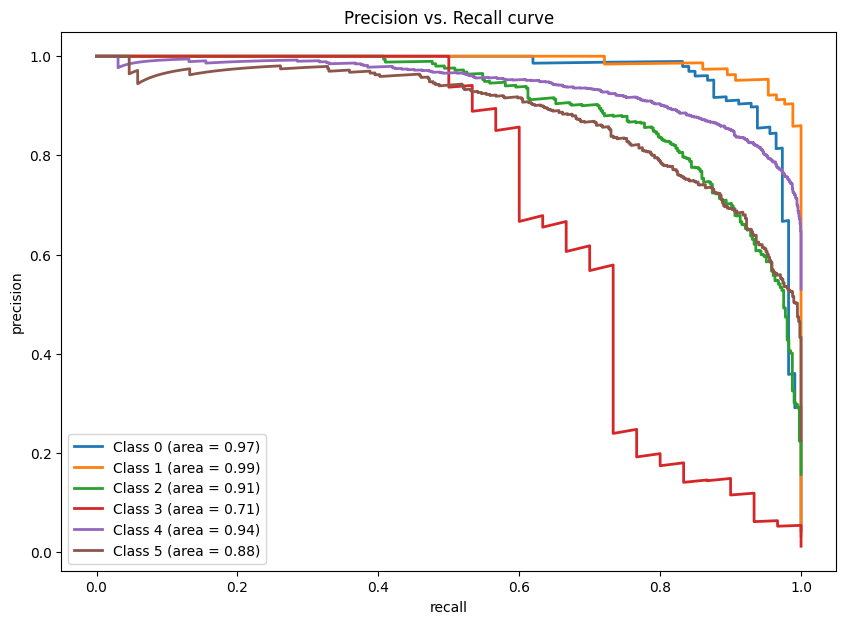

<Figure size 1500x1000 with 0 Axes>

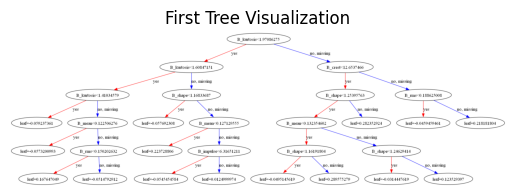

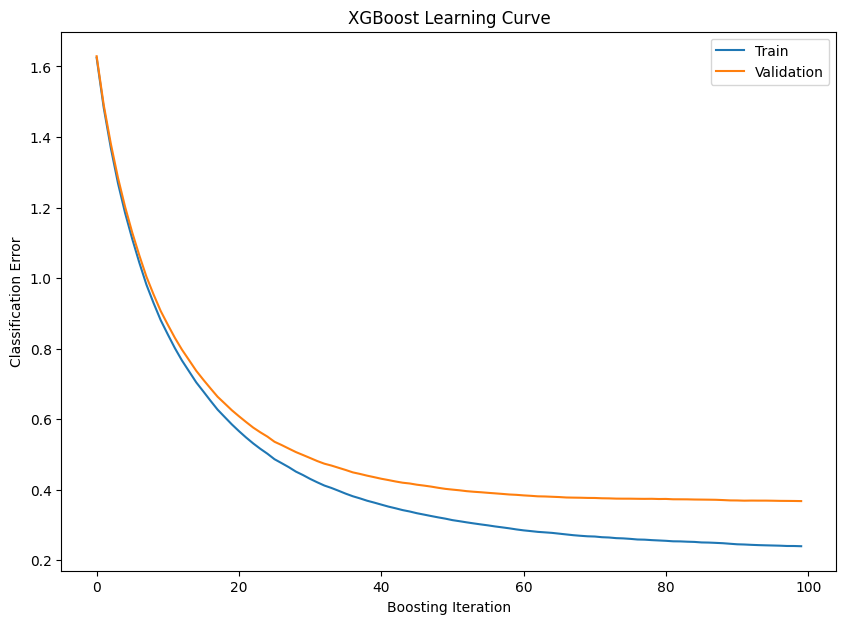

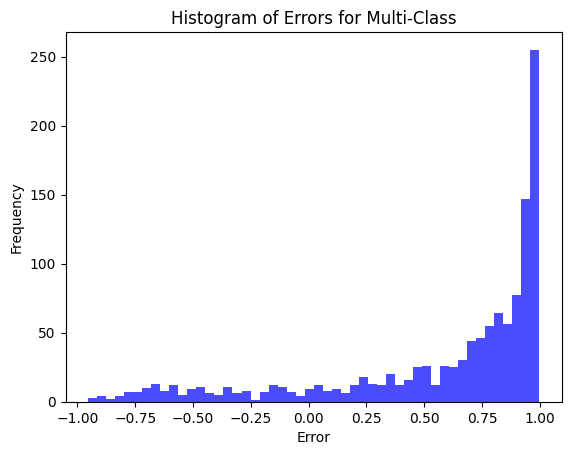

In [33]:
# Initialize XGB classifier

xgb_cl = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    booster="gbtree",
    tree_method="hist"
)  
xgb_cl.fit(X_train, y_train)
preds = xgb_cl.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds, average='macro')  # Choose 'macro', 'micro', or 'weighted' based on your needs
precision = precision_score(y_test, preds, average='macro')
recall = recall_score(y_test, preds, average='macro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# 1. PLOT FOR FEATURE IMPORTANCES
# Getting feature importances
importances = xgb_cl.feature_importances_
indices = np.argsort(importances)[::-1]

# Plotting the feature importances
plt.figure(figsize=(10, 7))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=45)
plt.tight_layout()
plt.ylabel('Relative Importance')
plt.show()



# 2. Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# 3. ROC Curve (only if binary classification)
if len(np.unique(y_test)) == 2:
    plt.figure(figsize=(10, 7))
    probas = xgb_cl.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probas)
    auc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# 5. Prediction Distribution
plt.figure(figsize=(10, 7))
sns.histplot(preds, label='Predicted', kde=True, color='blue')
sns.histplot(y_test, label='Actual', kde=True, color='red')
plt.title('Prediction vs Actual Distribution')
plt.legend()
plt.show()

# 6. Decision Boundary Plot (assuming 2D data)
if X_test.shape[1] == 2:  # This is a simplistic approach, more adjustments might be needed based on your dataset
    plt.figure(figsize=(10, 7))
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = xgb_cl.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', marker='o')
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


#7. Precision-Recall Curve
y_pred_probabilities = xgb_cl.predict_proba(X_test) # Plot the precision-recall curve for each class
n_classes = y_pred_probabilities.shape[1] # Get the number of classes

# One-hot encode the true labels for multi-class precision-recall calculation
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

plt.figure(figsize=(10, 7))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probabilities[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'Class {i} (area = {pr_auc:.2f})')

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

#8. Tree Visualization
plt.figure(figsize=(15, 10))
xgb.plot_tree(xgb_cl, num_trees=0)
plt.title('First Tree Visualization')
plt.show()

#9. Learning Curve
X_train_sub, X_test, y_train_sub, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
eval_set = [(X_train_sub, y_train_sub), (X_test, y_test)]
xgb_cl.fit(X_train_sub, y_train_sub, eval_metric="mlogloss", eval_set=eval_set, verbose=False)
results = xgb_cl.evals_result()
epochs = len(results['validation_0']['mlogloss'])

x_axis = range(0, epochs)
plt.figure(figsize=(10, 7))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
plt.legend()
plt.ylabel('Classification Error')
plt.xlabel('Boosting Iteration')
plt.title('XGBoost Learning Curve')
plt.show()


# 10. Plot histogram of errors
pred_probs = xgb_cl.predict_proba(X_test) # Compute the predicted probabilities

# Extract predicted probability of the true class for each instance
true_class_probs = np.take_along_axis(pred_probs, y_test[:, np.newaxis], axis=1).flatten()

# Extract maximum predicted probability of the non-true classes
max_non_true_probs = (np.where(pred_probs == true_class_probs[:, np.newaxis], -1, pred_probs)).max(axis=1)

errors = true_class_probs - max_non_true_probs # Compute errors as the difference between true class probability and max non-true class probability

plt.hist(errors, bins=50, facecolor='blue', alpha=0.7)
plt.title('Histogram of Errors for Multi-Class')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()


HYPERPARAMETER FOR GRADIENT BOOSTING

[I 2023-08-30 17:48:39,467] A new study created in memory with name: no-name-fe47fa6e-554e-4bdd-ad3f-4827c5e0c9b9
[I 2023-08-30 17:49:03,275] Trial 0 finished with value: 0.8427152317880795 and parameters: {'learning_rate_xgb': 0.010480965940635035, 'n_estimators_xgb': 799, 'max_depth_xgb': 2, 'subsample_xgb': 0.614743848026533, 'colsample_bytree_xgb': 0.8203491027867513, 'gamma_xgb': 2.5652061368082664}. Best is trial 0 with value: 0.8427152317880795.
[I 2023-08-30 17:49:24,628] Trial 1 finished with value: 0.9205298013245033 and parameters: {'learning_rate_xgb': 0.18361448346120704, 'n_estimators_xgb': 943, 'max_depth_xgb': 4, 'subsample_xgb': 0.9853312282408836, 'colsample_bytree_xgb': 0.919161125344899, 'gamma_xgb': 0.702688169438826}. Best is trial 1 with value: 0.9205298013245033.
[I 2023-08-30 17:49:33,132] Trial 2 finished with value: 0.8923841059602649 and parameters: {'learning_rate_xgb': 0.019851498533553037, 'n_estimators_xgb': 298, 'max_depth_xgb': 5, 'subsample_xgb': 0.61

Best Hyperparameters: {'learning_rate_xgb': 0.18361448346120704, 'n_estimators_xgb': 943, 'max_depth_xgb': 4, 'subsample_xgb': 0.9853312282408836, 'colsample_bytree_xgb': 0.919161125344899, 'gamma_xgb': 0.702688169438826}
Accuracy: 0.9205298013245033
F1 Score: 0.9324705067369966
Precision: 0.9567208591850648
Recall: 0.9122578361594624


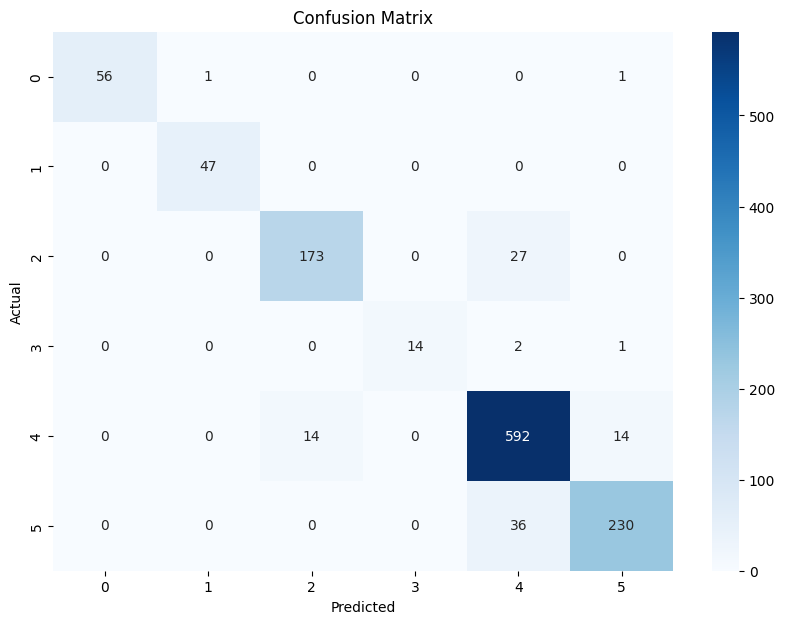

In [47]:
# Create an Optuna Study
study = optuna.create_study(direction="maximize")

# Define the objective function
def objective(trial):
    xgb_cl = xgb.XGBClassifier(
        learning_rate=trial.suggest_float("learning_rate_xgb", 0.01, 0.3),
        n_estimators=trial.suggest_int("n_estimators_xgb", 50, 1000),
        max_depth=trial.suggest_int("max_depth_xgb", 2, 10),
        subsample=trial.suggest_float("subsample_xgb", 0.5, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree_xgb", 0.5, 1.0),
        gamma=trial.suggest_float("gamma_xgb", 0, 5),
        booster="gbtree",
        tree_method="hist"
    )
    xgb_cl.fit(X_train, y_train)
    preds = xgb_cl.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    precision = precision_score(y_test, preds, average='macro')
    recall = recall_score(y_test, preds, average='macro')

    return accuracy  # Optuna maximizes the accuracy

# Conduct optimization trials
study.optimize(objective, n_trials=10)

# Get the best hyperparameters from the study
best_params = study.best_params
best_xgb_cl = xgb.XGBClassifier(
    learning_rate=best_params["learning_rate_xgb"],
    n_estimators=best_params["n_estimators_xgb"],
    max_depth=best_params["max_depth_xgb"],
    subsample=best_params["subsample_xgb"],
    colsample_bytree=best_params["colsample_bytree_xgb"],
    gamma=best_params["gamma_xgb"],
    booster="gbtree",
    tree_method="hist"
)
best_xgb_cl.fit(X_train, y_train)
preds = best_xgb_cl.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds, average='macro')
precision = precision_score(y_test, preds, average='macro')
recall = recall_score(y_test, preds, average='macro')
cm = confusion_matrix(y_test, preds)
cv_scores = cross_val_score(xgb_cl, X_train, y_train, cv=5)  # Assuming 5-fold CV
class_labels = ['normal', 'early', 'suspect', 'imminent_failure', 'inner_race_failure', 'stage_two_failure']

# Save intermediate results
intermediate_results = {
    "xgb_cl": xgb_cl,
    "preds": preds,
    "accuracy": accuracy,
    "f1": f1,
    "precision": precision,
    "recall": recall
}
joblib.dump(intermediate_results, "xgb_intermediate_results.pkl")

# Print performance metrics
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
# Print cross-validation results
print("\nCross-Validation Scores:", cv_scores)
print("Average CV Score:", np.mean(cv_scores))

# Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()



For Support Vector Machines

Accuracy: 0.5880989180834622
F1 Score: 0.33732100841899976
Precision: 0.5036701792882902
Recall: 0.33631951750115724

Cross-Validation Scores: [0.56788079 0.57332229 0.57249379 0.57332229 0.57912179]
Average CV Score: 0.5732281887664122


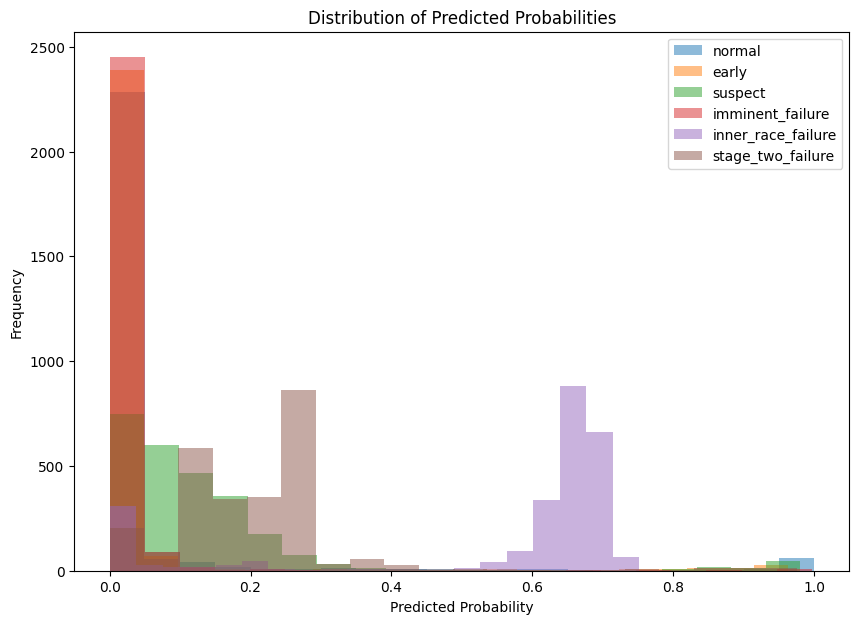

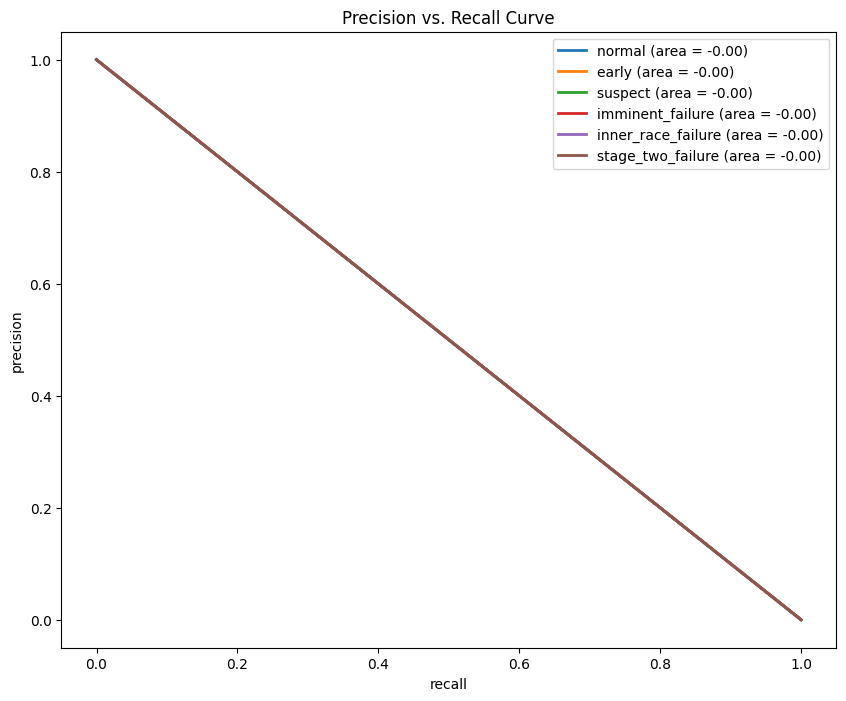

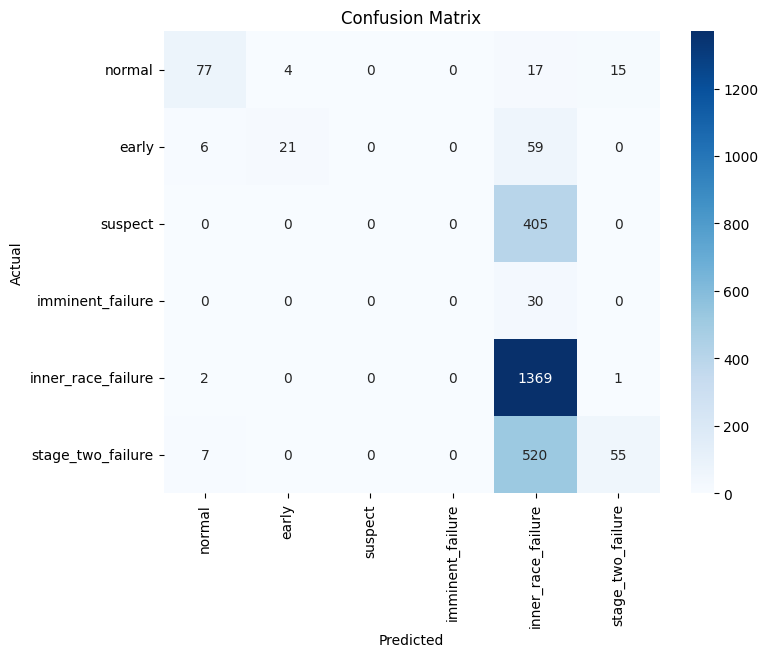

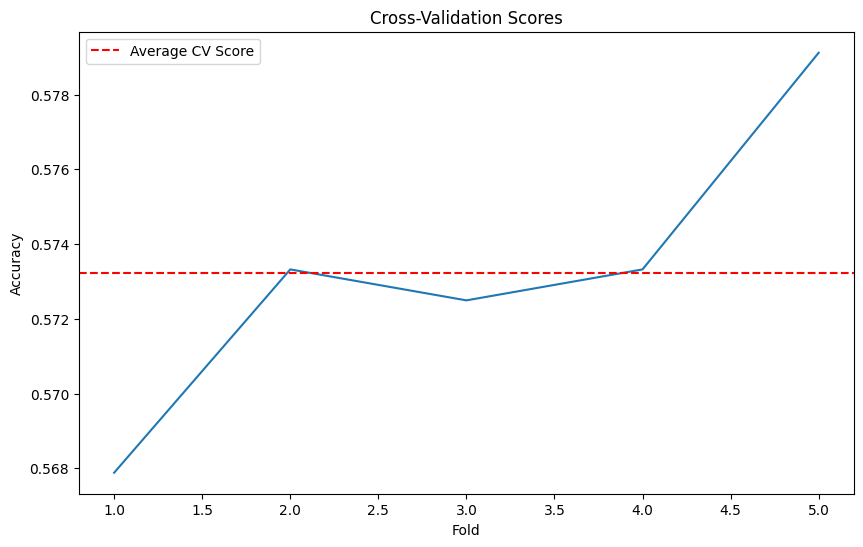

In [15]:
svm_cl = SVC(
    C=1.0,
    kernel="rbf",
    gamma="scale",
    probability=True
)

svm_cl.fit(X_train, y_train)
preds = svm_cl.predict(X_test)
    
# Calculate performance metrics
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds, average='macro')
precision = precision_score(y_test, preds, average='macro')
recall = recall_score(y_test, preds, average='macro')
cm = confusion_matrix(y_test, preds)
cv_scores = cross_val_score(svm_cl, X_train, y_train, cv=5)  # Assuming 5-fold CV
class_labels = ['normal', 'early', 'suspect', 'imminent_failure', 'inner_race_failure', 'stage_two_failure']

# Save intermediate results
intermediate_results = {
    "svm_cl": svm_cl,
    "preds": preds,
    "accuracy": accuracy,
    "f1": f1,
    "precision": precision,
    "recall": recall
}
joblib.dump(intermediate_results, "svm_intermediate_results.pkl")

# Print performance metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Print cross-validation results
print("\nCross-Validation Scores:", cv_scores)
print("Average CV Score:", np.mean(cv_scores))


# 1. Plot distribution of predicted probabilities
probs = svm_cl.predict_proba(X_test)
plt.figure(figsize=(10, 7))
for i in range(probs.shape[1]):
    plt.hist(probs[:, i], bins=20, alpha=0.5, label=class_labels[i])
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()

# 2. Precision-Recall Curve
y_test_binarized = label_binarize(y_test, classes=class_labels)
y_score = svm_cl.decision_function(X_test)
n_classes = y_test_binarized.shape[1]
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_labels[i]} (area = {avg_precision:.2f})')

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall Curve")
plt.show()

# 3. Confusion Matrix
class_labels = ['normal', 'early', 'suspect', 'imminent_failure', 'inner_race_failure', 'stage_two_failure']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 4. Plotting CV results
plt.figure(figsize=(10,6))
sns.lineplot(x=range(1, len(cv_scores)+1), y=cv_scores)
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label="Average CV Score")
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.legend()
plt.show()

PARAMS OPTIMISATION FOR SUPPORT VECTOR MACHINE

[I 2023-09-05 01:09:24,054] A new study created in memory with name: no-name-aeebc96e-e9d8-4fcf-ad3d-b9aefda2f9dd
[I 2023-09-05 01:09:42,927] Trial 0 finished with value: 0.5556414219474498 and parameters: {'kernel': 'linear', 'C_svm': 18.12527856920975, 'gamma': 1, 'coef0': -0.35752317709476467, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5556414219474498.
[I 2023-09-05 01:10:01,873] Trial 1 finished with value: 0.6707882534775889 and parameters: {'kernel': 'linear', 'C_svm': 5.2427872446116766, 'gamma': 'scale', 'coef0': 0.7547161537122082, 'class_weight': None}. Best is trial 1 with value: 0.6707882534775889.
[I 2023-09-05 01:10:11,683] Trial 2 finished with value: 0.6823802163833076 and parameters: {'kernel': 'rbf', 'C_svm': 87.35852478215163, 'gamma': 'auto', 'coef0': -0.4993325107386446, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6823802163833076.
[I 2023-09-05 01:10:16,453] Trial 3 finished with value: 0.5301391035548686 and parameters: {'kernel': 

Accuracy: 0.7534775888717156
F1 Score: 0.7184063990331859
Precision: 0.7816917697538076
Recall: 0.6959983816316996

Cross-Validation Scores: [0.56788079 0.57332229 0.57249379 0.57332229 0.57912179]
Average CV Score: 0.5732281887664122
confusion_matrix
[[ 101    4    0    0    2    6]
 [   7   77    0    1    1    0]
 [   1    0  230    0  172    2]
 [   0    0    4   11   10    5]
 [   3    0   44    2 1191  132]
 [  36    0    4    0  202  340]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77       113
           1       0.95      0.90      0.92        86
           2       0.82      0.57      0.67       405
           3       0.79      0.37      0.50        30
           4       0.75      0.87      0.81      1372
           5       0.70      0.58      0.64       582

    accuracy                           0.75      2588
   macro avg       0.78      0.70      0.72      2588
weighted avg       0.76      0.75     

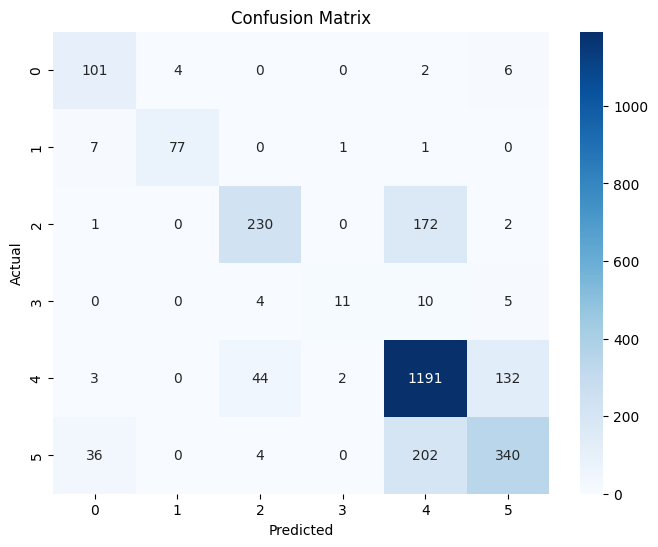

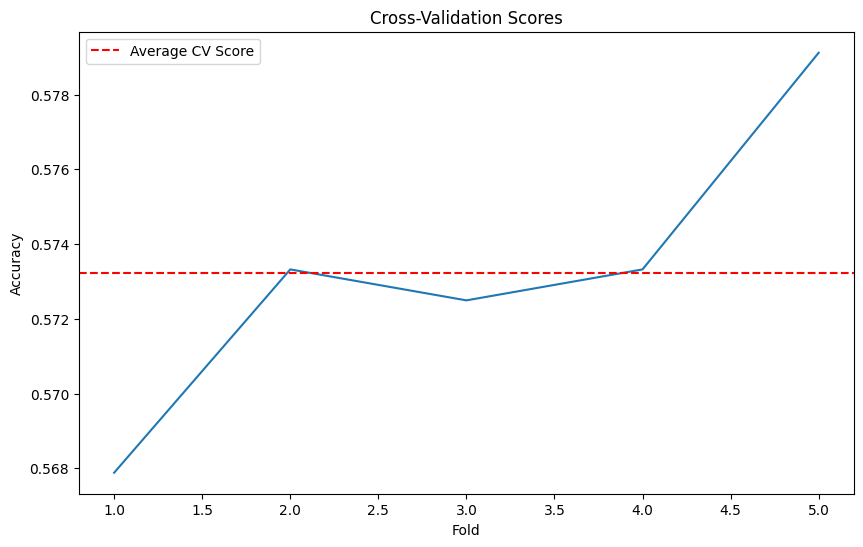

In [16]:
# Create an Optuna Study
study = optuna.create_study(direction="maximize")

def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid'])

    svm_cl = SVC(
        C=trial.suggest_float("C_svm", 0.1, 100, log=True),
        kernel=kernel,
        gamma=trial.suggest_categorical("gamma", ['scale', 'auto', 0.1, 1, 10]),
        degree=trial.suggest_int('degree', 1, 5) if kernel=='poly' else 3, 
        coef0=trial.suggest_float('coef0', -1.0, 1.0),
        class_weight=trial.suggest_categorical('class_weight', [None, 'balanced'])
    )
    svm_cl.fit(X_train, y_train)
    preds = svm_cl.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    precision = precision_score(y_test, preds, average='macro')
    recall = recall_score(y_test, preds, average='macro')

    return accuracy  # Optuna maximizes the accuracy

# Conduct optimization trials
study.optimize(objective, n_trials=10)

# Get the best hyperparameters from the study
best_params = study.best_params
best_svm_cl = SVC(
    C=best_params["C_svm"],
    kernel=best_params["kernel"],
    gamma=best_params["gamma"],
)

best_svm_cl.fit(X_train, y_train)
preds = best_svm_cl.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds, average='macro')
precision = precision_score(y_test, preds, average='macro')
recall = recall_score(y_test, preds, average='macro')
cm = confusion_matrix(y_test, preds)
cv_scores = cross_val_score(svm_cl, X_train, y_train, cv=5)  # Assuming 5-fold CV
class_labels = ['normal', 'early', 'suspect', 'imminent_failure', 'inner_race_failure', 'stage_two_failure']

# Save intermediate results
intermediate_results = {
    "svm_cl": svm_cl,
    "preds": preds,
    "accuracy": accuracy,
    "f1": f1,
    "precision": precision,
    "recall": recall
}
joblib.dump(intermediate_results, "svm_intermediate_results.pkl")


print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
# Print cross-validation results
print("\nCross-Validation Scores:", cv_scores)
print("Average CV Score:", np.mean(cv_scores))

print("confusion_matrix")
print(cm)

# Classification Report
class_names = [str(label) for label in set(y_test)]  # Convert labels to strings
classification_rep = classification_report(y_test, preds, target_names=class_names)
print("Classification Report:")
print(classification_rep)

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plotting CV results
plt.figure(figsize=(10,6))
sns.lineplot(x=range(1, len(cv_scores)+1), y=cv_scores)
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label="Average CV Score")
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.legend()
plt.show()

For Logistic Regression

Accuracy: 0.615919629057187
F1 Score (Macro): 0.4423280244238252
Precision: 0.5441148336281466
Recall: 0.41640068459987084
Confusion Matrix:
[[  50    7    0    0    9   47]
 [   2   57    0    0    0   27]
 [   0    0  155    0  249    1]
 [   0    5    0    0   25    0]
 [   0    0    0    0 1292   80]
 [  27    1    1    0  513   40]]
Correlation Coefficient:
0.43645409236912996
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.44      0.52       113
           1       0.81      0.66      0.73        86
           2       0.99      0.38      0.55       405
           3       0.00      0.00      0.00        30
           4       0.62      0.94      0.75      1372
           5       0.21      0.07      0.10       582

    accuracy                           0.62      2588
   macro avg       0.54      0.42      0.44      2588
weighted avg       0.58      0.62      0.55      2588



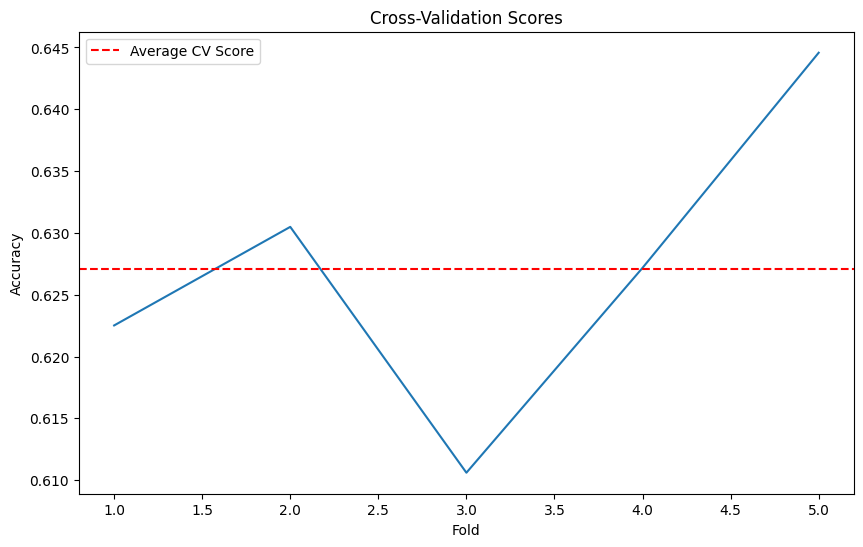

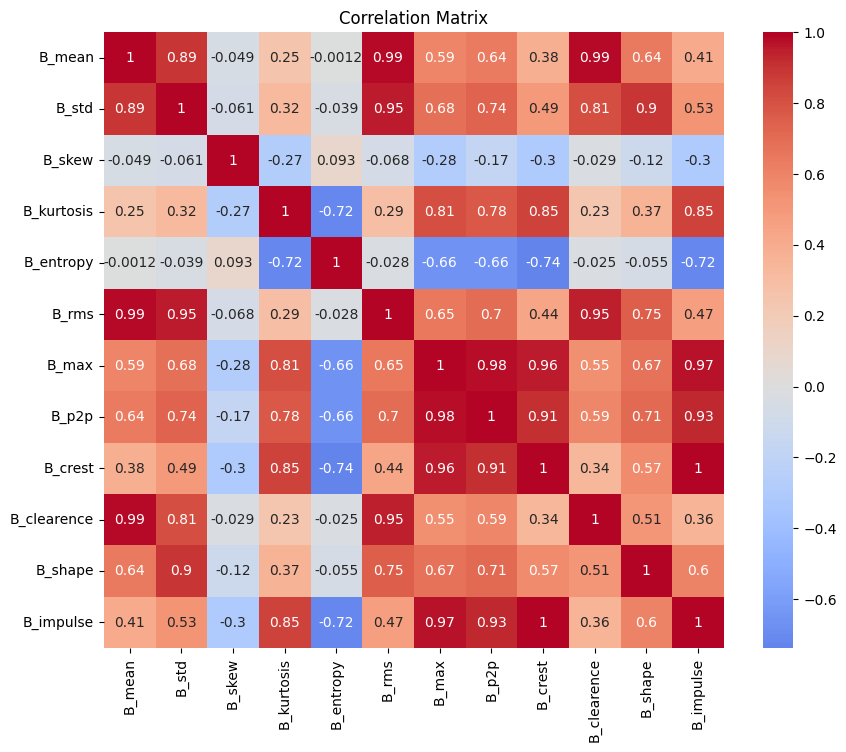

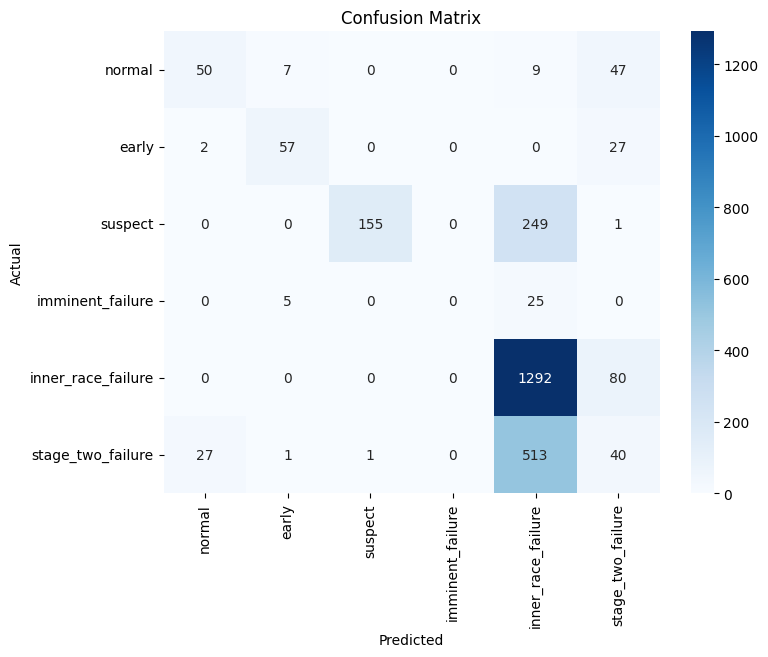

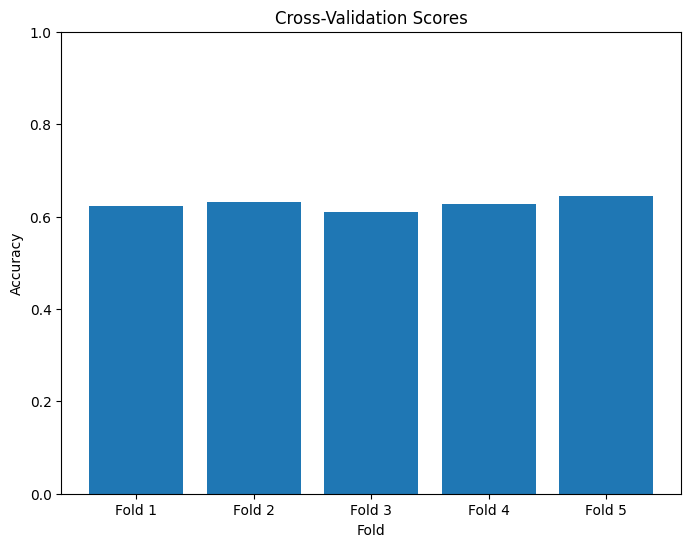

In [15]:
import joblib
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Initialize Logistic Regression classifier
lr_cl = LogisticRegression(max_iter=10000)
lr_cl.fit(X_train, y_train)
preds = lr_cl.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, preds)
f1_macro = f1_score(y_test, preds, average='macro')  
f1_weighted = f1_score(y_test, preds, average='macro')
precision = precision_score(y_test, preds, average='macro')
recall = recall_score(y_test, preds, average='macro')
cm = confusion_matrix(y_test, preds)
corr = np.corrcoef(y_test, preds)[0, 1]  # calculate correlation coefficient
# Cross-validation
cv_scores = cross_val_score(lr_cl, X_train, y_train, cv=5)  # Assuming 5-fold CV, you can adjust as needed

# Save intermediate results
intermediate_results = {
    "lr_cl": lr_cl,
    "preds": preds,
    "accuracy": accuracy,
    "f1_macro": f1_macro,
    "precision": precision,
    "recall": recall
}
joblib.dump(intermediate_results, "intermediate_results.pkl")

# Print performance metrics and confusion matrix
print("Accuracy:", accuracy)
print("F1 Score (Macro):", f1_macro)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:")
print(cm)
print("Correlation Coefficient:")
print(corr)

# Classification Report
class_names = [str(label) for label in set(y_test)]  # Convert labels to strings
classification_rep = classification_report(y_test, preds, target_names=class_names)
print("Classification Report:")
print(classification_rep)

# Plotting CV results
plt.figure(figsize=(10,6))
sns.lineplot(x=range(1, len(cv_scores)+1), y=cv_scores)
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label="Average CV Score")
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.legend()
plt.show()

# 5. Correlation Matrices
correlation_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# 7. Confusion Matrix
# Class labels from the Counter output
class_labels = ['normal', 'early', 'suspect', 'imminent_failure', 'inner_race_failure', 'stage_two_failure']

# Create a heatmap of the confusion matrix with class labels as tick labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Fit the best Logistic Regression model (if not already fitted)
lr_cl.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(lr_cl, X_train, y_train, cv=5, scoring='accuracy')

# Plot cross-validation scores
plt.figure(figsize=(8, 6))
plt.bar(range(len(cv_scores)), cv_scores)
plt.xticks(range(len(cv_scores)), ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.ylim(0.0, 1.0)
plt.show()



PARAMS OTPIMISATION FOR LOGISTIC REGRESSION

[I 2023-08-30 19:41:15,112] A new study created in memory with name: no-name-332a2895-ed23-4d50-9f2d-0972b7028b72


[I 2023-08-30 19:41:19,578] Trial 0 finished with value: 0.3369205298013245 and parameters: {'C_logreg': 1.1257517292739254}. Best is trial 0 with value: 0.3369205298013245.
[I 2023-08-30 19:41:24,921] Trial 1 finished with value: 0.32284768211920534 and parameters: {'C_logreg': 937.3236360713963}. Best is trial 1 with value: 0.32284768211920534.
[I 2023-08-30 19:41:25,710] Trial 2 finished with value: 0.32615894039735094 and parameters: {'C_logreg': 15.668945882589934}. Best is trial 1 with value: 0.32284768211920534.
[I 2023-08-30 19:41:26,301] Trial 3 finished with value: 0.3369205298013245 and parameters: {'C_logreg': 0.028907633499425614}. Best is trial 1 with value: 0.32284768211920534.
[I 2023-08-30 19:41:26,644] Trial 4 finished with value: 0.3725165562913907 and parameters: {'C_logreg': 0.0012058995347412394}. Best is trial 1 with value: 0.32284768211920534.
[I 2023-08-30 19:41:27,181] Trial 5 finished with value: 0.32533112582781454 and parameters: {'C_logreg': 459.1983284241

Number of finished trials: 10
Best trial:
Value: 0.32284768211920534
Params:
    C_logreg: 937.3236360713963
Accuracy: 0.6605960264900662
F1 Score: 0.5683842937051761
Precision: 0.7684885938980602
Recall: 0.5296132523788669
Confusion Matrix:
[[ 33   2   0   0   4  19]
 [  2  41   0   0   3   1]
 [  1   0 102   0  97   0]
 [  0   0   1   3  13   0]
 [  1   0   1   0 595  23]
 [ 11   0   0   0 231  24]]


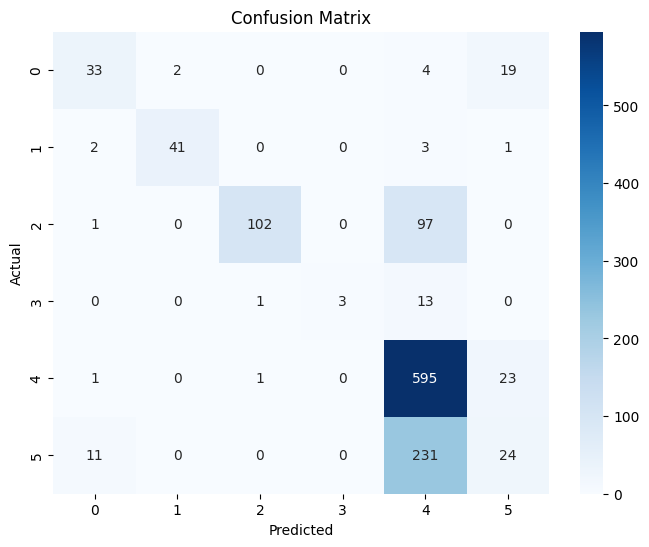

In [66]:
from sklearn.pipeline import Pipeline

def objective(trial):
    lr_cl = Pipeline([
        ('scaler', StandardScaler()), 
        ('logistic', LogisticRegression(
            C=trial.suggest_float("C_logreg", 1e-3, 1e3, log=True),
            penalty="l2",
            solver="lbfgs"
        ))
    ])
    
    lr_cl.fit(X_train, y_train)
    preds = lr_cl.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    precision = precision_score(y_test, preds, average='macro')
    recall = recall_score(y_test, preds, average='macro')
    
    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    
    # Save intermediate results
    intermediate_results = {
        "lr_cl": lr_cl,
        "preds": preds,
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "cm": cm
    }
    joblib.dump(intermediate_results, "intermediate_results.pkl")

    return 1 - accuracy

# Create an Optuna study and optimize it
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# After optimization, load the intermediate results
intermediate_results = joblib.load("intermediate_results.pkl")
best_lr_cl = intermediate_results["lr_cl"]
preds = intermediate_results["preds"]
accuracy = intermediate_results["accuracy"]
f1 = intermediate_results["f1"]
precision = intermediate_results["precision"]
recall = intermediate_results["recall"]
cm = intermediate_results["cm"]

# Print optimization results
print("Number of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value:", trial.value)
print("Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Print performance metrics and confusion matrix
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:")
print(cm)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

For LSTM Recurrent Neural Network

In [ ]:
# Define the LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(24, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # assuming 10 classes; adjust as necessary
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Assuming X_train and X_test are shaped properly for sequences
model.fit(X_train, y_train, epochs=20)

# Predictions
preds = model.predict(X_test)
pred_labels = tf.argmax(preds, axis=1).numpy()

print("LSTM Accuracy:", accuracy_score(y_test, pred_labels))

Epoch 1/10
189/189 [==============================] - 59s 162ms/step - loss: 1.2653 - accuracy: 0.5326 - val_loss: 1.1090 - val_accuracy: 0.5513
Epoch 2/10
189/189 [==============================] - 19s 98ms/step - loss: 1.0531 - accuracy: 0.5502 - val_loss: 1.0320 - val_accuracy: 0.5579
Epoch 3/10
189/189 [==============================] - 20s 108ms/step - loss: 1.0094 - accuracy: 0.5630 - val_loss: 0.9940 - val_accuracy: 0.5795
Epoch 4/10
189/189 [==============================] - 20s 105ms/step - loss: 0.9730 - accuracy: 0.5732 - val_loss: 0.9734 - val_accuracy: 0.5712
Epoch 5/10
189/189 [==============================] - 21s 112ms/step - loss: 0.9517 - accuracy: 0.5805 - val_loss: 0.9616 - val_accuracy: 0.5753
Epoch 6/10
189/189 [==============================] - 20s 105ms/step - loss: 0.9409 - accuracy: 0.5835 - val_loss: 1.0302 - val_accuracy: 0.5621
Epoch 7/10
189/189 [==============================] - 19s 101ms/step - loss: 0.9251 - accuracy: 0.5825 - val_loss: 0.9086 - val_acc

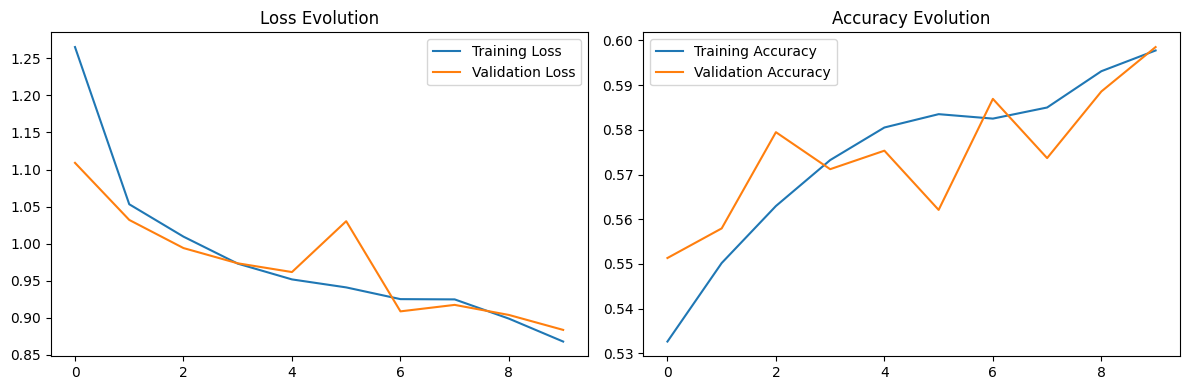

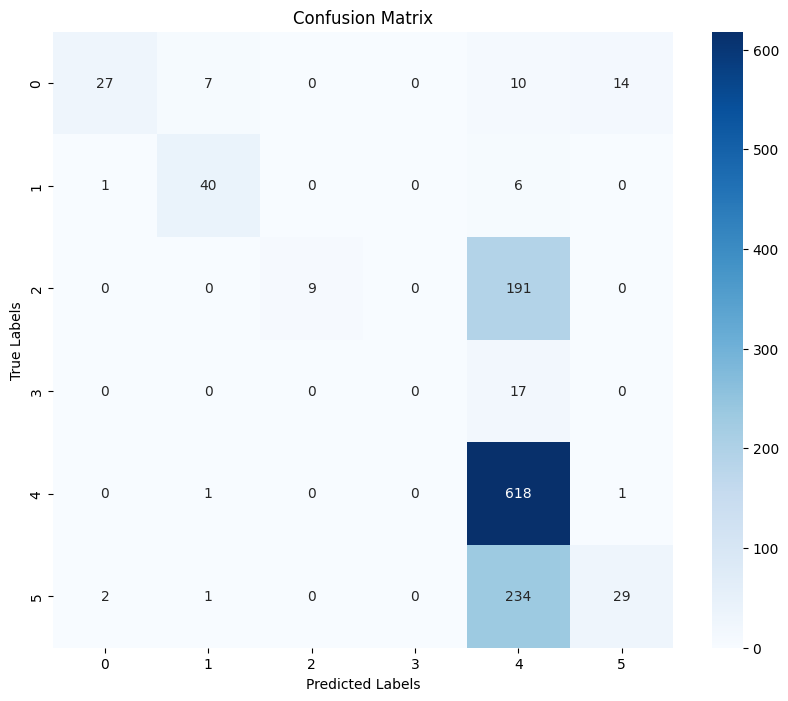

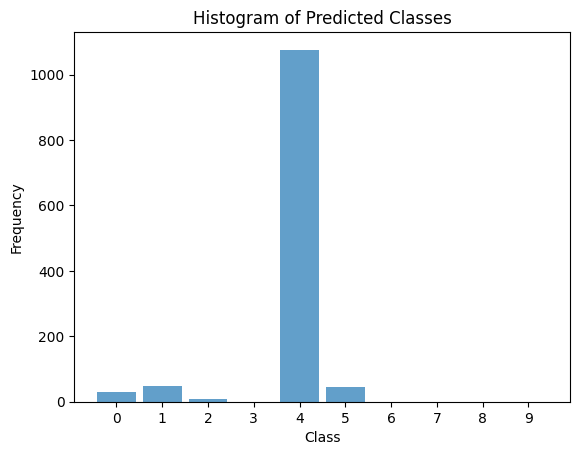

In [71]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import time
import joblib

# Define the LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(12, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Start timing
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Stop timing
end_time = time.time()

# Total Duration
print(f"Total Duration for Training and Prediction: {end_time - start_time:.2f} seconds")

# Predictions
preds = model.predict(X_test)
pred_labels = tf.argmax(preds, axis=1).numpy()

# Intermediate Results
intermediate_results = {
    "model": model,
    "history": history,
    "pred_labels": pred_labels
}

# Save intermediate results
joblib.dump(intermediate_results, "intermediate_results.pkl")

# Performance Metrics
print("\nLSTM Accuracy:", accuracy_score(y_test, pred_labels))
print("LSTM F1 Score:", f1_score(y_test, pred_labels, average='macro'))
print("LSTM Recall:", recall_score(y_test, pred_labels, average='macro'))
print("LSTM Precision:", precision_score(y_test, pred_labels, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, pred_labels))

# Plotting the Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()


# Confusion Matrix Visualization
cm = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Histogram of Predictions
plt.hist(pred_labels, bins=np.arange(-0.5, 10.5, 1), alpha=0.7, rwidth=0.85)
plt.title("Histogram of Predicted Classes")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 10, 1))
plt.show()

HYPERPARAMETER OPTIMIZATION FOR LSTM

[I 2023-08-30 20:47:41,914] A new study created in memory with name: no-name-0f4c279d-184b-40ad-999d-571e618e1586


38/38 [==============================] - 8s 173ms/step


[I 2023-08-30 21:20:18,498] Trial 0 finished with value: 0.2524834437086093 and parameters: {'units': 416, 'dense_units': 480}. Best is trial 0 with value: 0.2524834437086093.


38/38 [==============================] - 4s 78ms/step


[I 2023-08-30 21:32:00,908] Trial 1 finished with value: 0.29801324503311255 and parameters: {'units': 224, 'dense_units': 288}. Best is trial 0 with value: 0.2524834437086093.


38/38 [==============================] - 1s 12ms/step


[I 2023-08-30 21:33:43,370] Trial 2 finished with value: 0.3220198675496688 and parameters: {'units': 32, 'dense_units': 256}. Best is trial 0 with value: 0.2524834437086093.


38/38 [==============================] - 7s 178ms/step


[I 2023-08-30 22:05:56,836] Trial 3 finished with value: 0.2516556291390728 and parameters: {'units': 480, 'dense_units': 128}. Best is trial 3 with value: 0.2516556291390728.


38/38 [==============================] - 3s 46ms/step


[I 2023-08-30 22:15:36,973] Trial 4 finished with value: 0.2582781456953642 and parameters: {'units': 192, 'dense_units': 160}. Best is trial 3 with value: 0.2516556291390728.


38/38 [==============================] - 3s 51ms/step


[I 2023-08-30 22:22:14,202] Trial 5 finished with value: 0.2880794701986755 and parameters: {'units': 128, 'dense_units': 416}. Best is trial 3 with value: 0.2516556291390728.


38/38 [==============================] - 2s 29ms/step


[I 2023-08-30 22:27:06,995] Trial 6 finished with value: 0.2897350993377483 and parameters: {'units': 96, 'dense_units': 416}. Best is trial 3 with value: 0.2516556291390728.


38/38 [==============================] - 2s 18ms/step


[I 2023-08-30 22:29:23,410] Trial 7 finished with value: 0.3195364238410596 and parameters: {'units': 32, 'dense_units': 480}. Best is trial 3 with value: 0.2516556291390728.


38/38 [==============================] - 3s 32ms/step


[I 2023-08-30 22:35:09,962] Trial 8 finished with value: 0.2864238410596026 and parameters: {'units': 160, 'dense_units': 160}. Best is trial 3 with value: 0.2516556291390728.


38/38 [==============================] - 3s 49ms/step


[I 2023-08-30 22:42:57,041] Trial 9 finished with value: 0.26158940397350994 and parameters: {'units': 160, 'dense_units': 448}. Best is trial 3 with value: 0.2516556291390728.


Number of finished trials: 10
Best trial:
Value: 0.2516556291390728
Params:
    units: 480
    dense_units: 128
Accuracy: 0.7384105960264901
F1 Score: 0.696176028841592
Precision: 0.7702884467978849
Recall: 0.6652934416052549
Confusion Matrix:
[[ 47   1   0   0   3   7]
 [  2  44   0   0   1   0]
 [  0   0 122   0  76   2]
 [  0   1   0   4  11   1]
 [  0   0  19   0 530  71]
 [  6   3   6   2 104 145]]


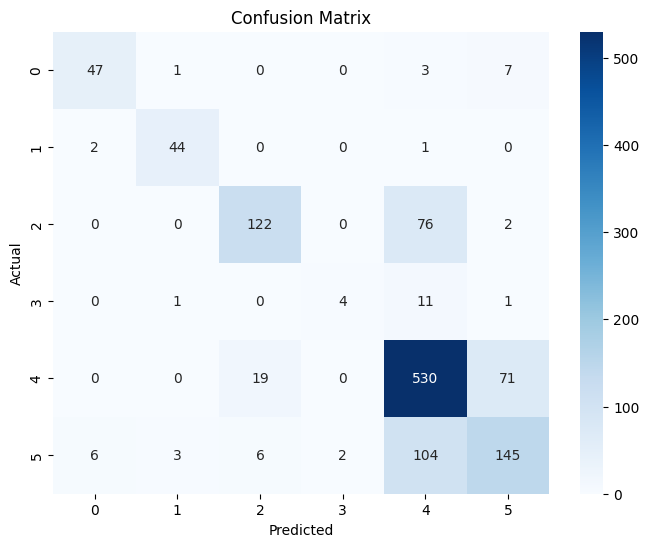

In [79]:
# Reshape input data for LSTM
sequence_length = 12
X_train_reshaped = X_train.values.reshape(-1, sequence_length, 1)
X_test_reshaped = X_test.values.reshape(-1, sequence_length, 1)

# Define the LSTM model
def build_lstm_model(trial):
    model = keras.Sequential()

    # Tune the number of LSTM units
    hp_units = trial.suggest_int('units', low=32, high=512, step=32)
    model.add(layers.LSTM(units=hp_units, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))

    model.add(layers.Flatten())

    # Tune the number of units in the Dense layer
    hp_dense_units = trial.suggest_int('dense_units', low=32, high=512, step=32)
    model.add(layers.Dense(units=hp_dense_units, activation='relu'))

    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Define the Optuna objective function
def objective(trial):
    model = build_lstm_model(trial)

    # Train the model
    model.fit(X_train_reshaped, y_train, epochs=10, verbose=0)

    preds = model.predict(X_test_reshaped)
    pred_labels = np.argmax(preds, axis=1)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, pred_labels)
    f1 = f1_score(y_test, pred_labels, average='macro')
    precision = precision_score(y_test, pred_labels, average='macro')
    recall = recall_score(y_test, pred_labels, average='macro')

    # Confusion matrix
    cm = confusion_matrix(y_test, pred_labels)

    # Save intermediate results
    intermediate_results = {
        "model": model,
        "pred_labels": pred_labels,
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "cm": cm
    }
    joblib.dump(intermediate_results, "intermediate_results.pkl")

    return 1 - accuracy

# Create an Optuna study and optimize it
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# After optimization, load the intermediate results
intermediate_results = joblib.load("intermediate_results.pkl")
best_model = intermediate_results["model"]
pred_labels = intermediate_results["pred_labels"]
accuracy = intermediate_results["accuracy"]
f1 = intermediate_results["f1"]
precision = intermediate_results["precision"]
recall = intermediate_results["recall"]
cm = intermediate_results["cm"]

# Print optimization results
print("Number of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value:", trial.value)
print("Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Print performance metrics and confusion matrix
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Gated Recurrent Unit (GRU) model

[I 2023-08-30 23:54:41,765] A new study created in memory with name: no-name-2a273064-29ef-4310-af3c-bc8b28d59e08


38/38 [==============================] - 6s 78ms/step


[I 2023-08-31 00:01:06,580] Trial 0 finished with value: 0.29470198675496684 and parameters: {'units': 192, 'dense_units': 32}. Best is trial 0 with value: 0.29470198675496684.


38/38 [==============================] - 7s 125ms/step


[I 2023-08-31 00:21:46,904] Trial 1 finished with value: 0.26821192052980136 and parameters: {'units': 320, 'dense_units': 512}. Best is trial 1 with value: 0.26821192052980136.


38/38 [==============================] - 4s 62ms/step


[I 2023-08-31 00:31:21,414] Trial 2 finished with value: 0.2582781456953642 and parameters: {'units': 192, 'dense_units': 384}. Best is trial 2 with value: 0.2582781456953642.


38/38 [==============================] - 2s 19ms/step


[I 2023-08-31 00:33:23,249] Trial 3 finished with value: 0.2814569536423841 and parameters: {'units': 32, 'dense_units': 224}. Best is trial 2 with value: 0.2582781456953642.


38/38 [==============================] - 3s 50ms/step


[I 2023-08-31 00:45:35,258] Trial 4 finished with value: 0.2466887417218543 and parameters: {'units': 224, 'dense_units': 192}. Best is trial 4 with value: 0.2466887417218543.


38/38 [==============================] - 3s 58ms/step


[I 2023-08-31 00:54:57,182] Trial 5 finished with value: 0.26158940397350994 and parameters: {'units': 192, 'dense_units': 416}. Best is trial 4 with value: 0.2466887417218543.


38/38 [==============================] - 2s 35ms/step


[I 2023-08-31 01:00:03,138] Trial 6 finished with value: 0.3029801324503312 and parameters: {'units': 128, 'dense_units': 288}. Best is trial 4 with value: 0.2466887417218543.


38/38 [==============================] - 7s 148ms/step


[I 2023-08-31 01:28:49,336] Trial 7 finished with value: 0.2798013245033113 and parameters: {'units': 448, 'dense_units': 384}. Best is trial 4 with value: 0.2466887417218543.


38/38 [==============================] - 5s 110ms/step


[I 2023-08-31 01:47:21,164] Trial 8 finished with value: 0.2574503311258278 and parameters: {'units': 320, 'dense_units': 384}. Best is trial 4 with value: 0.2466887417218543.


38/38 [==============================] - 2s 22ms/step


[I 2023-08-31 01:50:34,337] Trial 9 finished with value: 0.2880794701986755 and parameters: {'units': 96, 'dense_units': 128}. Best is trial 4 with value: 0.2466887417218543.


Number of finished trials (GRU): 10
Best trial (GRU):
Value: 0.2466887417218543
Params:
    units: 224
    dense_units: 192
Accuracy (GRU): 0.7119205298013245
F1 Score (GRU): 0.5989715275875414
Precision (GRU): 0.6771460296048705
Recall (GRU): 0.5956699469427124
Confusion Matrix (GRU):
[[ 51   3   0   0   1   3]
 [  1  46   0   0   0   0]
 [  0   0 104   0  96   0]
 [  0   1   0   0  16   0]
 [  0   0   9   0 597  14]
 [  5   4   7   0 188  62]]


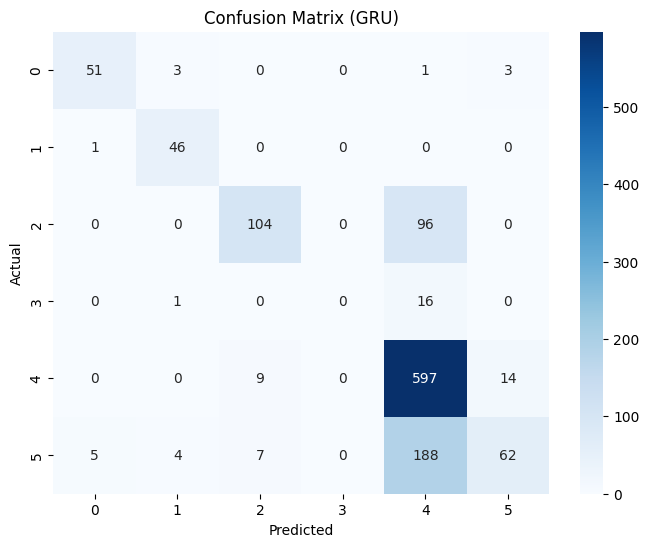

In [86]:
# Convert DataFrame to NumPy array and reshape
X_train_array = X_train.values
X_test_array = X_test.values

X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], -1)
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], -1)

sequence_length = X_train_reshaped.shape[1]
num_features = X_train_reshaped.shape[2]

# Define the GRU model
def build_gru_model(trial):
    model = keras.Sequential()

    hp_units = trial.suggest_int('units', low=32, high=512, step=32)
    model.add(layers.GRU(units=hp_units, activation='relu', return_sequences=True, input_shape=(sequence_length, num_features)))

    model.add(layers.Flatten())

    hp_dense_units = trial.suggest_int('dense_units', low=32, high=512, step=32)
    model.add(layers.Dense(units=hp_dense_units, activation='relu'))

    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def gru_objective(trial):
    model = build_gru_model(trial)

    model.fit(X_train_reshaped, y_train, epochs=20, verbose=0)

    preds = model.predict(X_test_reshaped)
    pred_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(y_test, pred_labels)
    f1 = f1_score(y_test, pred_labels, average='macro')
    precision = precision_score(y_test, pred_labels, average='macro')
    recall = recall_score(y_test, pred_labels, average='macro')

    cm = confusion_matrix(y_test, pred_labels)

    intermediate_results = {
        "model": model,
        "pred_labels": pred_labels,
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "cm": cm
    }
    joblib.dump(intermediate_results, "intermediate_results_gru.pkl")

    return 1 - accuracy

# Create an Optuna study and optimize it for GRU
study_gru = optuna.create_study(direction="minimize")
study_gru.optimize(gru_objective, n_trials=10)

# After optimization, load intermediate results for GRU
intermediate_results_gru = joblib.load("intermediate_results_gru.pkl")
best_model_gru = intermediate_results_gru["model"]
pred_labels_gru = intermediate_results_gru["pred_labels"]
accuracy_gru = intermediate_results_gru["accuracy"]
f1_gru = intermediate_results_gru["f1"]
precision_gru = intermediate_results_gru["precision"]
recall_gru = intermediate_results_gru["recall"]
cm_gru = intermediate_results_gru["cm"]

# Print optimization results for GRU
print("Number of finished trials (GRU):", len(study_gru.trials))
print("Best trial (GRU):")
trial_gru = study_gru.best_trial
print("Value:", trial_gru.value)
print("Params:")
for key, value in trial_gru.params.items():
    print(f"    {key}: {value}")

# Print performance metrics and confusion matrix for GRU
print("Accuracy (GRU):", accuracy_gru)
print("F1 Score (GRU):", f1_gru)
print("Precision (GRU):", precision_gru)
print("Recall (GRU):", recall_gru)
print("Confusion Matrix (GRU):")
print(cm_gru)

# Plot Confusion Matrix for GRU
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gru, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (GRU)')
plt.show()

**From now on, only X axis data will be used**

So data acquired from y axis will be excluded

In [ ]:
x_axis_cols = ["Bx_"+tf for tf in time_features_list]
print(x_axis_cols)
X_x = X.copy()
X_x = X[x_axis_cols]
cols = ['B_mean','B_std','B_skew','B_kurtosis','B_entropy',
        'B_rms','B_max','B_p2p','B_crest', 'B_clearence', 'B_shape', 'B_impulse']
X_x.columns = cols
X_x_train, X_x_test, y_train, y_test = train_test_split(X_x, y, test_size = 0.3, random_state =1)

**Model Selection**
Now we can compare several learning algorithms

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
                    #"Gaussian Process",
                    "Decision Tree", "Logistic Regression", "Random Forest", "Neural Net", "AdaBoost",
                    "Naive Bayes", "QDA", "XGBoost", "CatBoost", "LightGBoost",
                    ]

classifiers = [
    # KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    # GaussianProcessClassifier(1.0 * RBF(1.0)),
    # DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    LogisticRegression(max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    xgb.XGBClassifier(),
    cb.CatBoostClassifier(verbose=False),
    lgbm.LGBMClassifier(),
    
]

# Lists to store results
scores = []

for name, clf in zip(names, classifiers):
    print("Training " + name + "...")

    clf.fit(X_train, y_train) # Train model
    predicted_labels = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    labels = ['N', 'F']
    
    scores.append(score)

    print('Score of ' + name + ' is: ' + str(score))
    print('Classification Report for ' + name + ':')
    print(classification_report(y_test, predicted_labels, target_names=labels))
    #cm = confusion_matrix(y_test, predicted_labels)
    #cm_display = ConfusionMatrixDisplay(cm, display_labels=labels).plot()

    cm = confusion_matrix(y_test, predicted_labels)
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax)
    ax.set_title(name + " Confusion Matrix")
    plt.tight_layout()  # Add spacing between plots
    plt.show()

#     plt.show()

# Create a DataFrame and sort by R2 Score in descending order
results_df = pd.DataFrame(list(zip(names, scores)), columns=['Model Name', 'Accuracy']).sort_values(by=["Accuracy"], ascending=False)

print(results_df)      

**Hyperparameter Tuning**
Since accuracy score of the last 3 base model, namely XGBoost, CatBoost, LightBoost, are the highest ones, we will continue with one of them in further investigations.
Parameters of the selected model will be tuned with optuna library
Typical values were given as interval of parameters.

The purpose of the given function is to define an objective function for optimizing hyperparameters using Optuna for an XGBoost classifier. The code then uses Optuna to create a study for hyperparameter optimization with the direction of maximizing accuracy. The optimize method runs the objective function for a specified number of trials (in this case, 20) with different hyperparameter configurations.

After the optimization process is complete, the best set of hyperparameters found during the study is obtained using study.best_params. The study.best_params will give the hyperparameter configuration that resulted in the highest accuracy during the optimization process. These hyperparameters can be used to build the final XGBoost classifier for the given dataset.

[I 2023-08-30 23:15:31,894] A new study created in memory with name: no-name-b24820bc-8287-4f4a-a848-144b9ae879db
[I 2023-08-30 23:16:00,409] Trial 0 finished with value: 0.5128844380378723 and parameters: {'hidden_dim': 189, 'window_size': 6, 'lr': 0.021092604290461763, 'epochs': 39}. Best is trial 0 with value: 0.5128844380378723.
[I 2023-08-30 23:16:14,078] Trial 1 finished with value: 0.5108878016471863 and parameters: {'hidden_dim': 130, 'window_size': 15, 'lr': 0.0012920578890095117, 'epochs': 91}. Best is trial 0 with value: 0.5128844380378723.
[I 2023-08-30 23:18:14,322] Trial 2 finished with value: 0.5112970471382141 and parameters: {'hidden_dim': 168, 'window_size': 14, 'lr': 0.05405793103979387, 'epochs': 53}. Best is trial 0 with value: 0.5128844380378723.
[I 2023-08-30 23:18:50,470] Trial 3 finished with value: 0.5121951103210449 and parameters: {'hidden_dim': 116, 'window_size': 20, 'lr': 0.01670461632376624, 'epochs': 191}. Best is trial 0 with value: 0.5128844380378723.

Number of finished trials: 20
Best trial:
Value: 0.5365448594093323
Params:
    hidden_dim: 200
    window_size: 5
    lr: 0.0003260633072519137
    epochs: 155
Accuracy: 0.512073278427124
F1 Score: 0.11288546255506608
Precision: 0.08534554537885096
Recall: 0.16666666666666666
Confusion Matrix:
[[  0   0   0   0  57   0]
 [  0   0   0   0  46   0]
 [  0   0   0   0 200   0]
 [  0   0   0   0  17   0]
 [  0   0   0   0 615   0]
 [  0   0   0   0 266   0]]


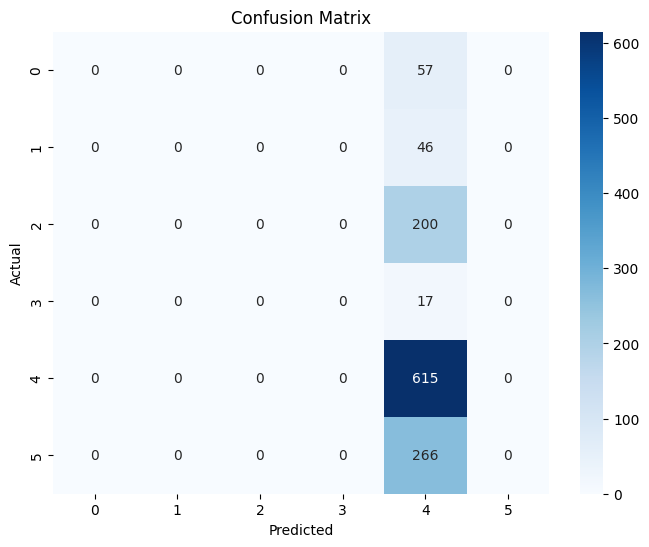

In [80]:
import torch.nn as nn
import torch.optim as optim


# Define a simple feedforward neural network with a sliding window
class SlidingWindowNN(nn.Module):
    def __init__(self, window_size, input_dim, hidden_dim, output_dim):
        super(SlidingWindowNN, self).__init__()
        self.window_size = window_size
        self.fc1 = nn.Linear(window_size * input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Apply sliding window and flatten
        x = x.unfold(1, self.window_size, 1).reshape(x.shape[0], -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

def train_sliding_window_nn(model, criterion, optimizer, epochs, X_train_tensor, y_train_tensor):
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

def sliding_window_objective(trial):
    input_dim = X_train.shape[1]
    output_dim = len(set(y_train))  # Assuming y_train is a list or array of labels
    hidden_dim = trial.suggest_int("hidden_dim", 10, 200)
    window_size = trial.suggest_int("window_size", 5, 20)
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    epochs = trial.suggest_int("epochs", 10, 200)

    model = SlidingWindowNN(window_size, input_dim, hidden_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train_segments = torch.FloatTensor(np.array([X_train[i:i+window_size] for i in range(len(X_train) - window_size + 1)]))
    y_train_segments = torch.LongTensor(np.array([y_train[i+window_size-1] for i in range(len(y_train) - window_size + 1)]))

    train_sliding_window_nn(model, criterion, optimizer, epochs, X_train_segments, y_train_segments)

    with torch.no_grad():
        X_test_segments = torch.FloatTensor(np.array([X_test[i:i+window_size] for i in range(len(X_test) - window_size + 1)]))
        outputs = model(X_test_segments)
        _, preds = torch.max(outputs, 1)
        accuracy = (preds == torch.LongTensor(y_test[window_size-1:])).float().mean().item()

        # Calculate other performance metrics
        # You can add similar calculations for F1, precision, and recall
        f1 = f1_score(y_test[window_size-1:], preds, average='macro')
        precision = precision_score(y_test[window_size-1:], preds, average='macro')
        recall = recall_score(y_test[window_size-1:], preds, average='macro')

        # Confusion matrix
        cm = confusion_matrix(y_test[window_size-1:], preds)

        # Save intermediate results
        intermediate_results = {
            "model": model,
            "preds": preds,
            "accuracy": accuracy,
            "f1": f1,
            "precision": precision,
            "recall": recall,
            "cm": cm
        }
        torch.save(intermediate_results, "intermediate_results.pt")

    return accuracy

# Create an Optuna study and optimize the sliding window neural network
study_sliding = optuna.create_study(direction="maximize")
study_sliding.optimize(sliding_window_objective, n_trials=20)
best_sliding_params = study_sliding.best_params

# After optimization, load intermediate results
intermediate_results = torch.load("intermediate_results.pt")
best_sliding_model = intermediate_results["model"]
preds = intermediate_results["preds"]
accuracy = intermediate_results["accuracy"]
f1 = intermediate_results["f1"]
precision = intermediate_results["precision"]
recall = intermediate_results["recall"]
cm = intermediate_results["cm"]

# Print optimization results
print("Number of finished trials:", len(study_sliding.trials))
print("Best trial:")
trial = study_sliding.best_trial
print("Value:", trial.value)
print("Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Print performance metrics and confusion matrix
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
